In [102]:
%config InlineBackend.figure_format = 'retina'

In [103]:
import os
import re
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from glob import glob
from copy import deepcopy
from statannotations.Annotator import Annotator
from sklearn.metrics import auc, roc_auc_score, roc_curve
from scipy.stats import pearsonr, chi2_contingency, linregress, ranksums, spearmanr
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3
import matplotlib as mpl
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import font_manager

In [104]:
label_dict = {'Normal':0,'Tumor':1}

In [105]:
sns.set_style('ticks')

In [106]:
method_color_dict = {'scMalignantFinder':"#E53935", 'PreCanCell':"#1E88E5", 'ikarus':'#43A047', 'Cancer-Finder':'#fdaa48'}

In [107]:
group_colors = [
    "#E53935", "#1E88E5", "#FFB300", "#43A047", "#9B26B0", "#3F51B4", "#02A9F3", "#00BBD3", "#009687", "#8BC34A",
    "#CCDC39", "#FFEB3A", "#FF9800", "#FF5721", "#795447", "#5F7D8B", "#E57272", "#F06192", "#B967C7", "#7985CB",
    "#4EC3F7", "#4CD0E0", "#4CB6AC", "#ADD480", "#DCE674", "#FFF176", "#FFB74C", "#FF8A65", "#A0877F", "#90A4AD",
    "#C52727", "#AC1357", "#6A1A99", "#273492", "#0177BD", "#00838E", "#00685B", "#548B2E", "#9E9D24", "#F8A725",
    "#EE6C00", "#D84314", "#4D332D", "#37464E", "#EE9999", "#F38EB1", "#CD92D8", "#9FA7D9", "#80D3F9", "#7FDEEA",
    "#7FCBC4", "#C5E0A5", "#E5ED9B", "#FFF49D", "#FFCC7F", "#FFAB91", "#BBAAA4", "#B0BEC5", "#FF6E00", "#202020",
    "#1A5E1F", "#311A92", "#FFC006", "#9E9E9E", "#4CAE50", "#6639B7", "#FFD44E", "#DFDFDF", "#80C684", "#9474CC",
    "#FF9F00", "#606060", "#388D3B", "#512CA7", "#FFDF81", "#EDEDED", "#A5D6A6", "#B29DDA", "#FFF8E0", "#F9F9F9"]

In [108]:
sc.settings.set_figure_params(figsize=(5,5), dpi=100, facecolor='white')

In [109]:
os.chdir('/mnt/home/qnyu/workspace/scOmics/malignantModel/multi_tissue')

In [110]:
meta1_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/Normal/TabulaSapiens_Epithelial/anno.tsv', index_col=0, sep='\t')
meta2_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/Metadata.txt', sep='\t', index_col=0).iloc[1:]

/tmp/ipykernel_28420/1816872587.py:2: DtypeWarning: Columns (4,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  meta2_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/Metadata.txt', sep='\t', index_col=0).iloc[1:]


In [111]:
anno_df = pd.read_excel('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/SubTable_1_add_is_carcinoma_zsy_20230814.xlsx')

In [112]:
meta2_df = meta2_df.loc[meta2_df['Cell_line'].isin(anno_df[anno_df['Cancer_Type_zsy']=='Carcinoma']['Name'].unique())]

In [113]:
cancer_tissue_dict = {
    'Lung Cancer':['Lung'],
    'Head and Neck Cancer': ['Salivary_Gland','Tongue'],
    'Skin Cancer':['Skin'],
    'Breast Cancer':['Mammary'],
    'Esophageal Cancer':[],
    'Ovarian Cancer':[],
    'Pancreatic Cancer':['Pancreas'],
    'Colon/Colorectal Cancer':['Large_Intestine'],
    'Endometrial/Uterine Cancer':['Uterus'],
    'Kidney Cancer':['Kidney'],
    'Liver Cancer':['Liver'],
    'Bladder Cancer':['Bladder'],
    'Gastric Cancer':[],
    'Thyroid Cancer':[],
    'Bile Duct Cancer':[],
    'Prostate Cancer':['Prostate'],
    'Gallbladder Cancer':[]
}

In [114]:
meta_df_ls = []
for cancer in cancer_tissue_dict.keys():
    tissue = '/'.join(cancer_tissue_dict[cancer])
    cancer_cells = meta2_df[meta2_df['Cancer_type']==cancer].index.tolist()
    normal_cells = meta1_df[meta1_df['tissue_in_publication'].isin(cancer_tissue_dict[cancer])].index.tolist()
    cancer_meta_df = pd.DataFrame({'Type':[cancer]*len(cancer_cells)+[tissue]*len(normal_cells), 
                                   'Cancer':[cancer]*len(cancer_cells+normal_cells)}, 
                                  index=cancer_cells+normal_cells)
    meta_df_ls.append(cancer_meta_df)

In [115]:
refine_meta_df = pd.concat(meta_df_ls, axis=0)

In [116]:
test_prefixs = ['cellLineTabula','LC2','LC3','CRC1','CRC2','HCC']

test_adata_dict = {}
for prefix in test_prefixs:
    if prefix == 'cellLineTabula':
        adata = sc.read_h5ad(f'./data/test_{prefix}.h5ad')
        adata.obs = pd.concat([adata.obs,refine_meta_df], axis=1)
        test_adata_dict[prefix] = adata
    else:
        test_adata_dict[prefix] = sc.read_h5ad(f'./data/test_{prefix}.h5ad')

In [117]:
test_method_dict = {}
for prefix in test_prefixs:
    test_other_df = pd.read_csv(f'./file/prediction/other_method.test_{prefix}.tsv', sep='\t', index_col=0)
    test_gene_df = pd.read_csv(f'./file/prediction/test_{prefix}.gene.tsv', sep='\t', index_col=0)
    test_score_df = pd.read_csv(f'./file/prediction/test_{prefix}.score.tsv', sep='\t', index_col=0)
    
    test_gene_df = test_gene_df.rename(columns={'RF':'RandomForest (gene-based)', 'LR':'LogisticRegression (gene-based)', 'XGBoost':'XGBoost (gene-based)'})
    test_score_df = test_score_df.rename(columns={'RF':'RandomForest (signature-based)', 'LR':'LogisticRegression (signature-based)', 'XGBoost':'XGBoost (signature-based)'})
    cancer_finder_df = pd.read_csv(f'/mnt/home/qnyu/software/SequencingCancerFinder-master/test_{prefix}.csv', index_col=0)
    cancer_finder_df['predict'][cancer_finder_df['predict'] > 0.5] = 1
    cancer_finder_df['predict'][cancer_finder_df['predict'] != 1 ] = 0
    cancer_finder_df['predict'] = cancer_finder_df['predict'].map(lambda x: 'Tumor' if x==1 else 'Normal')
    cancer_finder_df.columns = ['Cancer-Finder']
    test_method_dict[prefix] = pd.concat([test_gene_df, test_score_df, test_other_df, cancer_finder_df], axis=1)

In [118]:
for prefix in test_prefixs:
    print(prefix)
    adata = test_adata_dict[prefix]
    print(adata.obs['Raw_annotation'].value_counts())

cellLineTabula
Raw_annotation
Normal    104148
Tumor      53513
Name: count, dtype: int64
LC2
Raw_annotation
Normal    157259
Tumor      12312
Name: count, dtype: int64
LC3
Raw_annotation
Tumor     57654
Normal     6437
Name: count, dtype: int64
CRC1
Raw_annotation
Normal    49675
Tumor      8048
Name: count, dtype: int64
CRC2
Raw_annotation
Normal    3956
Tumor     2212
Name: count, dtype: int64
HCC
Raw_annotation
Tumor     18909
Normal     1873
Name: count, dtype: int64


In [119]:
df_ls = []

In [120]:
methods = ['RandomForest (gene-based)','LogisticRegression (gene-based)','XGBoost (gene-based)',
           'RandomForest (signature-based)','LogisticRegression (signature-based)','XGBoost (signature-based)', 
           'ikarus','PreCanCell','inferCNV','Cancer-Finder']

In [121]:
result_dict = {}

In [122]:
prefix = 'cellLineTabula'

In [123]:
result_df2 = pd.concat([test_adata_dict[prefix].obs['Raw_annotation'].to_frame(), test_method_dict[prefix]], axis=1)

metric_df = pd.DataFrame(index=['Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV'], columns=methods)
tumor_result_df = result_df2[result_df2['Raw_annotation']=='Tumor']
normal_result_df = result_df2[result_df2['Raw_annotation']=='Normal']
for method in methods:
    method_tumor_result_df = result_df2[result_df2[method]=='Tumor']
    method_normal_result_df = result_df2[result_df2[method]=='Normal']
    metric_df.loc['Accuracy',method] = result_df2[result_df2['Raw_annotation']==result_df2[method]].shape[0] / result_df2.shape[0]
    metric_df.loc['Sensitivity',method] = tumor_result_df[tumor_result_df['Raw_annotation']==tumor_result_df[method]].shape[0] / tumor_result_df.shape[0]
    metric_df.loc['Specificity',method] = normal_result_df[normal_result_df['Raw_annotation']==normal_result_df[method]].shape[0] / normal_result_df.shape[0]
    metric_df.loc['Balanced_accuracy',method] = (metric_df.loc['Sensitivity',method]+metric_df.loc['Specificity',method]) / 2
    if method_tumor_result_df.shape[0]==0:
        metric_df.loc['PPV',method] = np.nan
    else:
        metric_df.loc['PPV',method] = method_tumor_result_df[method_tumor_result_df['Raw_annotation']==method_tumor_result_df[method]].shape[0] / method_tumor_result_df.shape[0]
    if method_normal_result_df.shape[0]==0:
        metric_df.loc['NPV',method] = np.nan
    else:
        metric_df.loc['NPV',method] = method_normal_result_df[method_normal_result_df['Raw_annotation']==method_normal_result_df[method]].shape[0] / method_normal_result_df.shape[0]
metric_df = metric_df.applymap(float)

/tmp/ipykernel_28420/3429270805.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)


In [124]:
metric_df = metric_df.loc[:,['LogisticRegression (gene-based)','PreCanCell','ikarus','Cancer-Finder']]

In [125]:
metric_df = metric_df.rename(columns={'LogisticRegression (gene-based)':'scMalignantFinder'})

In [126]:
df_ls = []
for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
    if method == 'ikarus':
        pred_df = pd.read_csv(f'./file/proba/{method}/test_{prefix}/prediction.csv', index_col=0)['final_pred_proba_Tumor'].to_frame()
        pred_df.columns = [method]
        pred_df.index = range(pred_df.shape[0])
        df_ls.append(pred_df)
    elif method == 'scMalignantFinder':
        pred_df = pd.read_csv(f'./file/proba/{method}/test_{prefix}', index_col=0)['Tumor'].to_frame()
        pred_df.columns = [method]
        pred_df.index = range(pred_df.shape[0])
        df_ls.append(pred_df)
    elif method == 'PreCanCell':
        pred_df = pd.read_csv(f'./file/proba/{method}/test_{prefix}.csv', index_col=0, sep='\t')['freq_cancer'].to_frame()
        pred_df.columns = [method]
        pred_df.index = range(pred_df.shape[0])
        df_ls.append(pred_df)
    elif method == 'Cancer-Finder':
        pred_df = pd.read_csv(f'/mnt/home/qnyu/software/SequencingCancerFinder-master/test_{prefix}.csv', index_col=0)['predict'].to_frame()
        pred_df.columns = [method]
        pred_df.index = range(pred_df.shape[0])
        df_ls.append(pred_df)
        
combine_pred_df = pd.concat(df_ls, axis=1)

In [127]:
combine_pred_df['label'] = test_adata_dict[prefix].obs['Raw_annotation'].map(label_dict).tolist()

In [128]:
auc_dict = {}
for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
    print(method, roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values))
    auc_dict[method] = roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values)

scMalignantFinder 0.9937829532682965
PreCanCell 0.8918777225986291
ikarus 0.7234906579089071
Cancer-Finder 0.7210324501116161


In [129]:
tmp_metric_df = metric_df.T

In [130]:
tmp_metric_df['AUROC'] = tmp_metric_df.index.map(auc_dict)
metric_df = tmp_metric_df.T.loc[['AUROC','Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV']]

In [131]:
result_dict['cellLine'] = metric_df.loc['Sensitivity'].to_frame().T
result_dict['Tabula'] = metric_df.loc['Specificity'].to_frame().T

In [207]:
result_dict['cellLine']

,scMalignantFinder,PreCanCell,ikarus,Cancer-Finder,Metric
Sensitivity,0.999832,0.995833,0.863884,0.999944,Sensitivity


In [208]:
result_dict['Tabula']

,scMalignantFinder,PreCanCell,ikarus,Cancer-Finder,Metric
Specificity,0.809598,0.511733,0.584073,0.022382,Specificity


In [132]:
# result_dict[prefix] = metric_df

In [133]:
meta2_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/Metadata.txt', sep='\t', index_col=0).iloc[1:]

/tmp/ipykernel_28420/436292287.py:1: DtypeWarning: Columns (4,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  meta2_df = pd.read_csv('/mnt/home/qnyu/workspace/scOmics/Dataset/cellLine/panCancer/Metadata.txt', sep='\t', index_col=0).iloc[1:]


In [134]:
tmp_sen_ls = []
tmp_method_ls = []
for cellline in meta2_df['Cell_line'].unique():
    celline_cells = meta2_df[meta2_df['Cell_line']==cellline].index.tolist()
    for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
        if method == 'scMalignantFinder':
            sensitivity = sum(result_df2.loc[celline_cells,'LogisticRegression (gene-based)']=='Tumor') / len(celline_cells)
        else:
            sensitivity = sum(result_df2.loc[celline_cells,method]=='Tumor') / len(celline_cells)
        tmp_sen_ls.append(sensitivity)
        tmp_method_ls.append(method)

In [138]:
sen_plot_df = pd.DataFrame({'Sensitivity':tmp_sen_ls, 'Method':tmp_method_ls})

In [139]:
for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
    print(method, sen_plot_df[sen_plot_df['Method']==method]['Sensitivity'].min())

scMalignantFinder 0.9767441860465116
PreCanCell 0.8090909090909091
ikarus 0.0
Cancer-Finder 0.992619926199262


/tmp/ipykernel_28420/741447521.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Sensitivity', data=sen_plot_df, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']],
/tmp/ipykernel_28420/741447521.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Method', y='Sensitivity', data=sen_plot_df, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']],


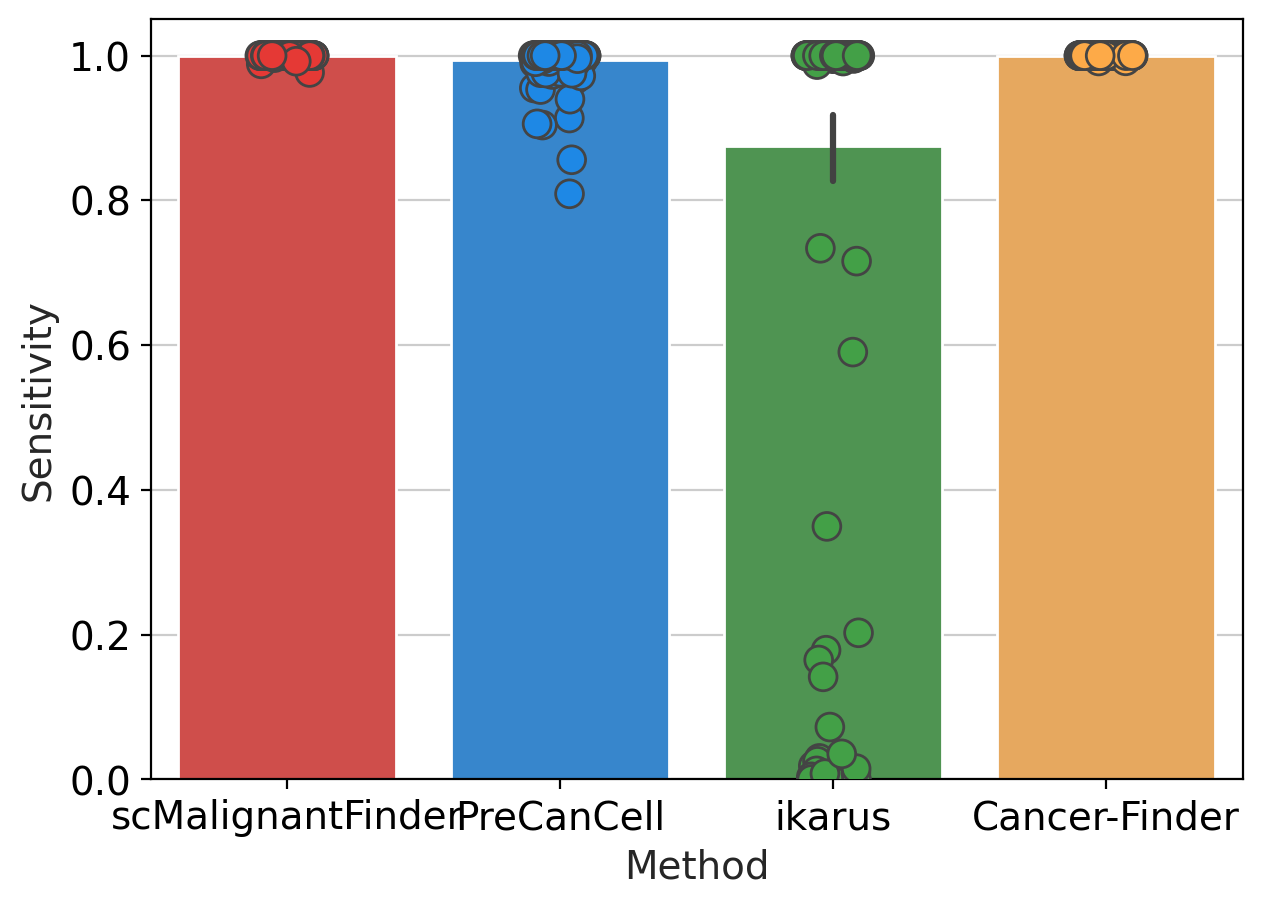

In [149]:
plt.figure(figsize=(7,5))
sns.barplot(x='Method', y='Sensitivity', data=sen_plot_df, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']], 
            linewidth=1)
sns.stripplot(x='Method', y='Sensitivity', data=sen_plot_df, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']], 
              linewidth=1, size=10)
plt.savefig(f'./plot/sensitive.barplot.new.pdf', bbox_inches='tight')

In [190]:
for method in ['PreCanCell','ikarus','Cancer-Finder']:
    print(method, ranksums(sen_plot_df[sen_plot_df['Method']=='scMalignantFinder']['Sensitivity'], sen_plot_df[sen_plot_df['Method']==method]['Sensitivity'])[1])

PreCanCell 0.0008875467020925114
ikarus 0.007679922429497513
Cancer-Finder 0.7935793513286717


In [143]:
tmp_spe_ls = []
tmp_method_ls = []
for tissue in meta1_df['tissue_in_publication'].unique():
    tissue_cells = meta1_df[meta1_df['tissue_in_publication']==tissue].index.tolist()
    for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
        if method == 'scMalignantFinder':
            specificity = sum(result_df2.loc[tissue_cells,'LogisticRegression (gene-based)']=='Normal') / len(tissue_cells)
        else:
            specificity = sum(result_df2.loc[tissue_cells,method]=='Normal') / len(tissue_cells)
        tmp_spe_ls.append(specificity)
        tmp_method_ls.append(method)

In [144]:
spe_plot_df = pd.DataFrame({'Specificity':tmp_spe_ls, 'Method':tmp_method_ls})

In [145]:
for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
    print(method, spe_plot_df[spe_plot_df['Method']==method]['Specificity'].min())

scMalignantFinder 0.11019283746556474
PreCanCell 0.05509641873278237
ikarus 8.2904990880451e-05
Cancer-Finder 0.00012003360941063497


In [191]:
for method in ['PreCanCell','ikarus','Cancer-Finder']:
    print(method, ranksums(spe_plot_df[spe_plot_df['Method']=='scMalignantFinder']['Specificity'], spe_plot_df[spe_plot_df['Method']==method]['Specificity'])[1])

PreCanCell 0.06418997117728065
ikarus 0.7637449284635762
Cancer-Finder 5.765865918921708e-07


/tmp/ipykernel_28420/2319900949.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Specificity', data=spe_plot_df, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']],
/tmp/ipykernel_28420/2319900949.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Method', y='Specificity', data=spe_plot_df, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']],


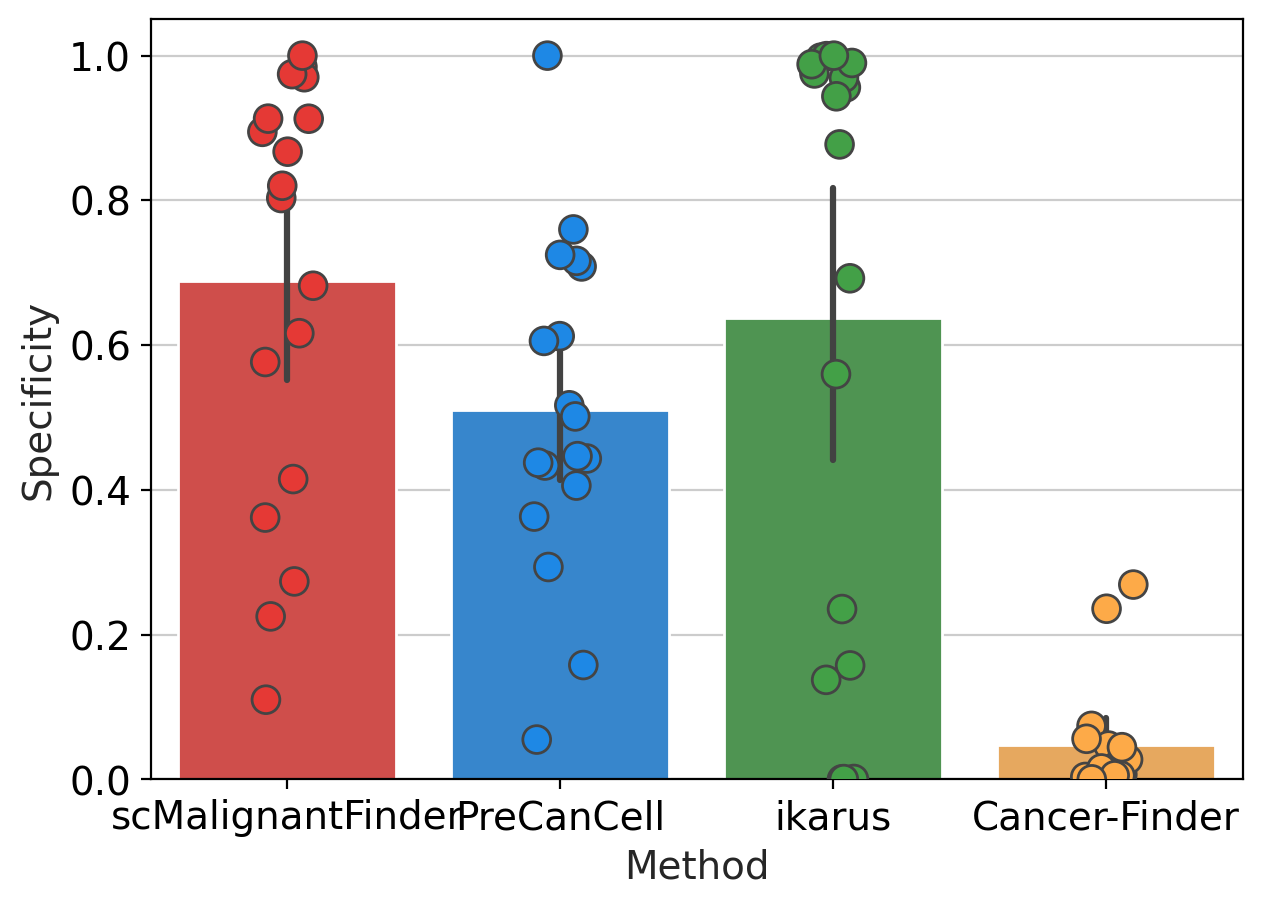

In [150]:
plt.figure(figsize=(7,5))
sns.barplot(x='Method', y='Specificity', data=spe_plot_df, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']], 
            linewidth=1)
sns.stripplot(x='Method', y='Specificity', data=spe_plot_df, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']], 
              linewidth=1, size=10)
plt.savefig(f'./plot/specificity.barplot.new.pdf', bbox_inches='tight')

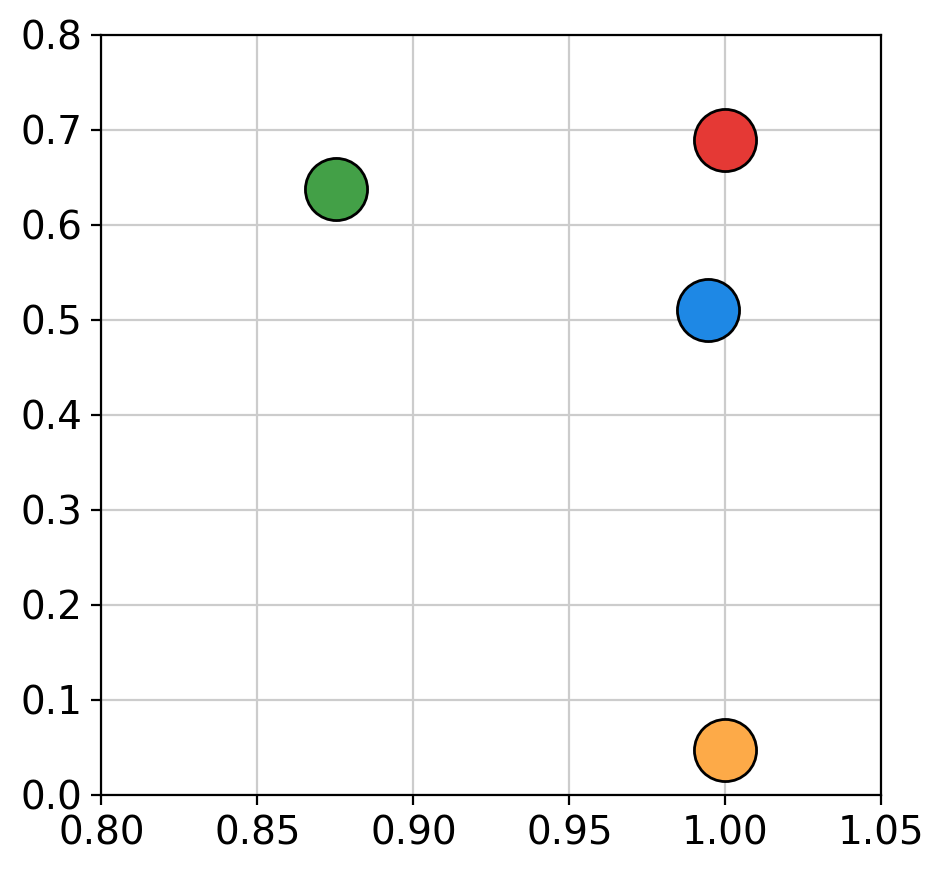

In [189]:
plt.figure(figsize=(5,5))
for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
    plt.scatter(sen_plot_df[sen_plot_df['Method']==method]['Sensitivity'].mean(), 
                spe_plot_df[spe_plot_df['Method']==method]['Specificity'].mean(), 
                color=method_color_dict[method], s=500, edgecolor='black')
_ = plt.xlim([0.8,1.05])
_ = plt.ylim([0,0.8])
plt.savefig(f'./plot/sensitivity_specificity.scatter.new.pdf', bbox_inches='tight')

In [192]:
for prefix in test_prefixs[1:]:
    result_df2 = pd.concat([test_adata_dict[prefix].obs['Raw_annotation'].to_frame(), test_method_dict[prefix]], axis=1)

    metric_df = pd.DataFrame(index=['Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV'], columns=methods)
    tumor_result_df = result_df2[result_df2['Raw_annotation']=='Tumor']
    normal_result_df = result_df2[result_df2['Raw_annotation']=='Normal']
    for method in methods:
        method_tumor_result_df = result_df2[result_df2[method]=='Tumor']
        method_normal_result_df = result_df2[result_df2[method]=='Normal']
        metric_df.loc['Accuracy',method] = result_df2[result_df2['Raw_annotation']==result_df2[method]].shape[0] / result_df2.shape[0]
        metric_df.loc['Sensitivity',method] = tumor_result_df[tumor_result_df['Raw_annotation']==tumor_result_df[method]].shape[0] / tumor_result_df.shape[0]
        metric_df.loc['Specificity',method] = normal_result_df[normal_result_df['Raw_annotation']==normal_result_df[method]].shape[0] / normal_result_df.shape[0]
        metric_df.loc['Balanced_accuracy',method] = (metric_df.loc['Sensitivity',method]+metric_df.loc['Specificity',method]) / 2
        if method_tumor_result_df.shape[0]==0:
            metric_df.loc['PPV',method] = np.nan
        else:
            metric_df.loc['PPV',method] = method_tumor_result_df[method_tumor_result_df['Raw_annotation']==method_tumor_result_df[method]].shape[0] / method_tumor_result_df.shape[0]
        if method_normal_result_df.shape[0]==0:
            metric_df.loc['NPV',method] = np.nan
        else:
            metric_df.loc['NPV',method] = method_normal_result_df[method_normal_result_df['Raw_annotation']==method_normal_result_df[method]].shape[0] / method_normal_result_df.shape[0]
    metric_df = metric_df.applymap(float)
    
    metric_df = metric_df.loc[:,['LogisticRegression (gene-based)','PreCanCell','ikarus','Cancer-Finder']]
    metric_df = metric_df.rename(columns={'LogisticRegression (gene-based)':'scMalignantFinder'})

    df_ls = []
    for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
        if method == 'ikarus':
            pred_df = pd.read_csv(f'./file/proba/{method}/test_{prefix}/prediction.csv', index_col=0)['final_pred_proba_Tumor'].to_frame()
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)
        elif method == 'scMalignantFinder':
            pred_df = pd.read_csv(f'./file/proba/{method}/test_{prefix}', index_col=0)['Tumor'].to_frame()
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)
        elif method == 'PreCanCell':
            pred_df = pd.read_csv(f'./file/proba/{method}/test_{prefix}.csv', index_col=0, sep='\t')['freq_cancer'].to_frame()
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)
        elif method == 'Cancer-Finder':
            pred_df = pd.read_csv(f'/mnt/home/qnyu/software/SequencingCancerFinder-master/test_{prefix}.csv', index_col=0)['predict'].to_frame()
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)

    combine_pred_df = pd.concat(df_ls, axis=1)

    combine_pred_df['label'] = test_adata_dict[prefix].obs['Raw_annotation'].map(label_dict).tolist()

    auc_dict = {}
    for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
        # print(method, roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values))
        auc_dict[method] = roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values)

    tmp_metric_df = metric_df.T

    tmp_metric_df['AUROC'] = tmp_metric_df.index.map(auc_dict)
    metric_df = tmp_metric_df.T.loc[['AUROC','Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV']]

    result_dict[prefix] = metric_df

/tmp/ipykernel_28420/3815239401.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_28420/3815239401.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_28420/3815239401.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_28420/3815239401.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_28420/3815239401.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)


In [193]:
other_test_prefixs = []
with open('/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/run_model.sh') as f:
    for line in f:
        other_test_prefixs.append(line.strip().split(' ')[2].split('.h5ad')[0])
other_test_prefixs.sort()
other_test_prefixs.remove('Data_Izar2020_Ovarian.10X.tpm_10x')

In [194]:
tissue_dict = {
    'Kidney':[x for x in other_test_prefixs if re.search('Kidney',x)],
    'Head and Neck':[x for x in other_test_prefixs if re.search('Head_and_Neck',x)],
    'Prostate':[x for x in other_test_prefixs if re.search('Prostate',x)],
    'Breast':[x for x in other_test_prefixs if re.search('Breast',x)],
    'Ovarian':[x for x in other_test_prefixs if re.search('Ovarian',x)],
    'Pancreas':[x for x in other_test_prefixs if re.search('Pancreas',x)],
}

In [195]:
other_test_adata_dict = {}
for prefix in other_test_prefixs:
    adata = sc.read_h5ad(f'/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/{prefix}.h5ad')
    adata.obs['Raw_annotation'] = adata.obs['cell_type'].map(lambda x: 'Tumor' if x=='Malignant' else 'Normal')
    adata.obs['Raw_annotation'] = pd.Categorical(adata.obs['Raw_annotation'])
    model_pred_df = pd.read_csv(f'/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/{prefix}.gene.tsv', sep='\t', index_col=0)
    infercnv_pred_df = pd.read_csv(f'/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/{prefix}.inferCNV.tsv', sep='\t', index_col=0)
    # ikarus_pred_df = pd.read_csv(f'/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/{prefix}.ikarus.tsv', sep='\t', index_col=0)
    ikarus_pred_df = pd.read_csv(f'./file/proba/ikarus/{prefix}/prediction.csv', index_col=0)
    precancell_pred_df = pd.read_csv(f'/mnt/home/qnyu/workspace/scOmics/Dataset/Pancancer_2023_Nature/file/{prefix}.PreCanCell.tsv', sep='\t', index_col=0)
    cancer_finder_df = pd.read_csv(f'/mnt/home/qnyu/software/SequencingCancerFinder-master/{prefix}.csv', index_col=0)
    cancer_finder_df['predict'][cancer_finder_df['predict'] > 0.5] = 1
    cancer_finder_df['predict'][cancer_finder_df['predict'] != 1 ] = 0
    cancer_finder_df['predict'] = cancer_finder_df['predict'].map(lambda x: 'Tumor' if x==1 else 'Normal')
    # adata.obs['RandomForest'] = model_pred_df.loc[adata.obs_names,'RF']
    adata.obs['scMalignantFinder'] = model_pred_df.loc[adata.obs_names,'LR']
    # adata.obs['XGBoost'] = model_pred_df.loc[adata.obs_names,'XGBoost']
    # adata.obs['ikarus'] = ikarus_pred_df.loc[adata.obs_names,'ikarus']
    adata.obs['ikarus'] = ikarus_pred_df['final_pred'].tolist()
    adata.obs['PreCanCell'] = precancell_pred_df.loc[adata.obs_names,'PreCanCell']
    adata.obs['inferCNV'] = infercnv_pred_df.loc[adata.obs_names,'inferCNV']
    adata.obs['Cancer-Finder'] = 'Unknown'
    overlap_cells = list(set(cancer_finder_df.index) & set(adata.obs_names))
    adata.obs.loc[overlap_cells,'Cancer-Finder'] = cancer_finder_df.loc[overlap_cells,'predict']
    other_test_adata_dict[prefix] = adata

In [196]:
meta1_df[['tissue_in_publication','donor_id']].drop_duplicates().shape[0]+meta2_df['Pool_ID'].unique().shape[0]+\
test_adata_dict['LC2'].obs['sample'].unique().shape[0]+test_adata_dict['LC3'].obs['batch'].unique().shape[0]+\
test_adata_dict['CRC1'].obs['HTAN Specimen ID'].unique().shape[0]+test_adata_dict['CRC2'].obs['Sample'].unique().shape[0]+\
test_adata_dict['HCC'].obs['sample'].unique().shape[0]+np.sum([x.obs['sample'].unique().shape[0] for x in other_test_adata_dict.values()])

633

In [197]:
methods = ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']

for tissue in tissue_dict.keys():
    result_df2 = pd.concat([other_test_adata_dict[x].obs[['Raw_annotation']+methods] for x in tissue_dict[tissue]])
    metric_df = pd.DataFrame(index=['Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV'], columns=methods)
    tumor_result_df = result_df2[result_df2['Raw_annotation']=='Tumor']
    normal_result_df = result_df2[result_df2['Raw_annotation']=='Normal']
    for method in methods:
        method_tumor_result_df = result_df2[result_df2[method]=='Tumor']
        method_normal_result_df = result_df2[result_df2[method]=='Normal']
        metric_df.loc['Accuracy',method] = result_df2[result_df2['Raw_annotation']==result_df2[method]].shape[0] / result_df2.shape[0]
        metric_df.loc['Sensitivity',method] = tumor_result_df[tumor_result_df['Raw_annotation']==tumor_result_df[method]].shape[0] / tumor_result_df.shape[0] if tumor_result_df.shape[0]!=0 else np.nan
        metric_df.loc['Specificity',method] = normal_result_df[normal_result_df['Raw_annotation']==normal_result_df[method]].shape[0] / normal_result_df.shape[0] if normal_result_df.shape[0]!=0 else np.nan
        metric_df.loc['Balanced_accuracy',method] = (metric_df.loc['Sensitivity',method]+metric_df.loc['Specificity',method]) / 2
        if method_tumor_result_df.shape[0]==0:
            metric_df.loc['PPV',method] = np.nan
        else:
            metric_df.loc['PPV',method] = method_tumor_result_df[method_tumor_result_df['Raw_annotation']==method_tumor_result_df[method]].shape[0] / method_tumor_result_df.shape[0]
        if method_normal_result_df.shape[0]==0:
            metric_df.loc['NPV',method] = np.nan
        else:
            metric_df.loc['NPV',method] = method_normal_result_df[method_normal_result_df['Raw_annotation']==method_normal_result_df[method]].shape[0] / method_normal_result_df.shape[0]
    metric_df = metric_df.applymap(float)
    
    df_ls = []
    for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
        if method == 'ikarus':
            tmp_ls = []
            for x in tissue_dict[tissue]:
                tmp_pred_df = pd.read_csv(f'./file/proba/{method}/{x}/prediction.csv', index_col=0)['final_pred_proba_Tumor'].to_frame()
                tmp_ls.append(tmp_pred_df)
            pred_df = pd.concat(tmp_ls)
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)
        elif method == 'scMalignantFinder':
            tmp_ls = []
            for x in tissue_dict[tissue]:
                tmp_pred_df = pd.read_csv(f'./file/proba/{method}/{x}', index_col=0)['Tumor'].to_frame()
                tmp_ls.append(tmp_pred_df)
            pred_df = pd.concat(tmp_ls)
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)
        elif method == 'PreCanCell':
            tmp_ls = []
            for x in tissue_dict[tissue]:
                tmp_pred_df = pd.read_csv(f'./file/proba/{method}/{x}.csv', index_col=0, sep='\t')['freq_cancer'].to_frame()
                tmp_ls.append(tmp_pred_df)
            pred_df = pd.concat(tmp_ls)
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)
        elif method == 'Cancer-Finder':
            tmp_ls = []
            for x in tissue_dict[tissue]:
                tmp_pred_df = pd.read_csv(f'/mnt/home/qnyu/software/SequencingCancerFinder-master/{x}.csv', index_col=0)['predict'].to_frame()
                tmp_ls.append(tmp_pred_df)
            pred_df = pd.concat(tmp_ls)
            pred_df.columns = [method]
            pred_df.index = range(pred_df.shape[0])
            df_ls.append(pred_df)

    combine_pred_df = pd.concat(df_ls, axis=1)

    combine_pred_df['label'] = pd.concat([other_test_adata_dict[x].obs['Raw_annotation'].to_frame() for x in tissue_dict[tissue]])['Raw_annotation'].map(label_dict).tolist()

    auc_dict = {}
    for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
        # print(method, roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values))
        auc_dict[method] = roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values)

    tmp_metric_df = metric_df.T

    tmp_metric_df['AUROC'] = tmp_metric_df.index.map(auc_dict)
    metric_df = tmp_metric_df.T.loc[['AUROC','Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV']]
    
    result_dict[tissue] = metric_df

/tmp/ipykernel_28420/2199797243.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_28420/2199797243.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_28420/2199797243.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_28420/2199797243.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_28420/2199797243.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_28420/2199797243.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)


In [198]:
df_ls = []
for prefix, result_df in result_dict.items():
    result_df['Metric'] = result_df.index.tolist()
    df_ls.append(pd.melt(result_df, id_vars=['Metric'], value_vars=methods))
    
result_metric_df = pd.concat(df_ls, axis=0)

In [199]:
pairs = [('scMalignantFinder','PreCanCell'),('scMalignantFinder','ikarus'),('scMalignantFinder','Cancer-Finder')]

/tmp/ipykernel_28420/3928802087.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_df, x="Method", y=metric, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']],
/tmp/ipykernel_28420/3928802087.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=plot_df, x="Method", y=metric, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']],
/tmp/ipykernel_28420/3928802087.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(dat

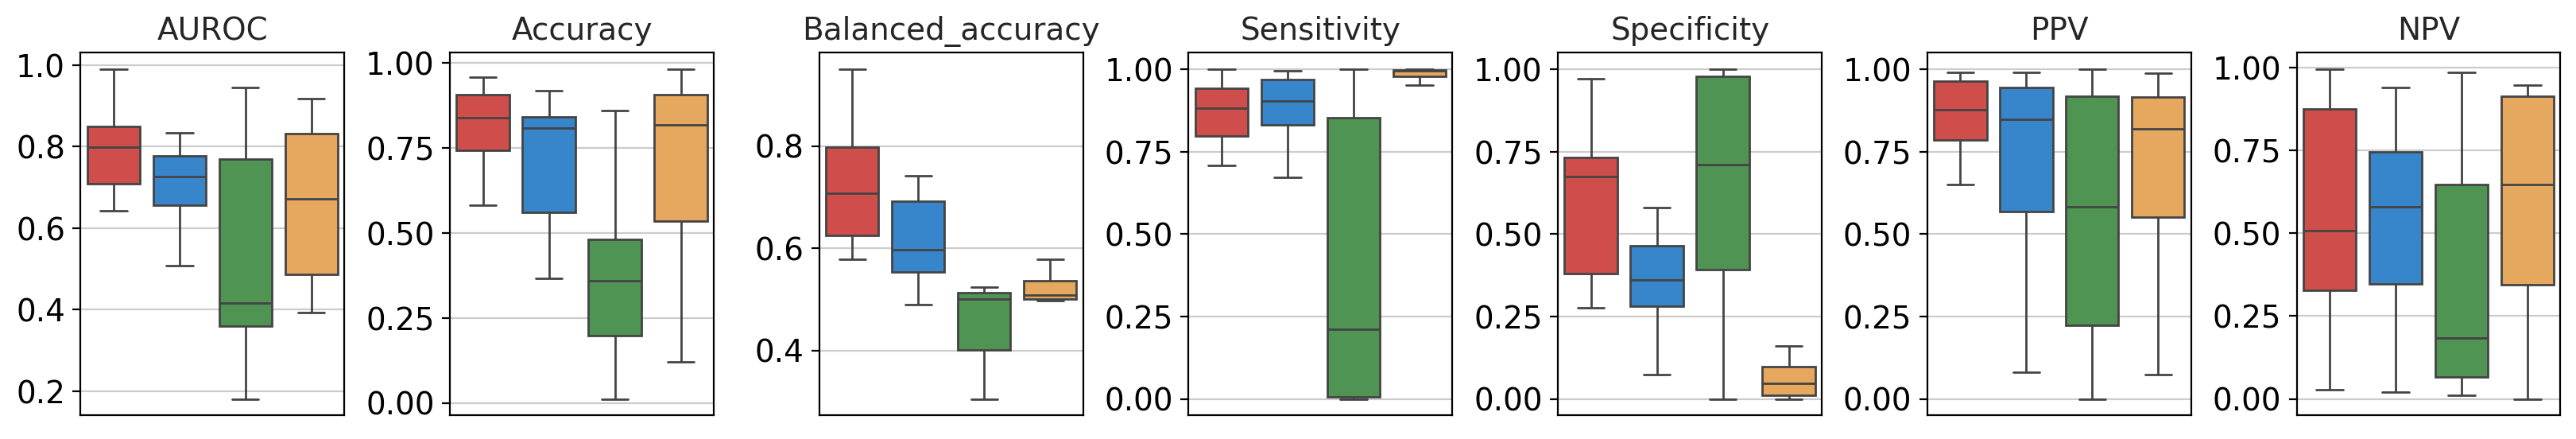

In [200]:
plt.figure(figsize=(20,3))
count = 1

for metric in result_df.index:
    plot_df = result_metric_df[result_metric_df['Metric']==metric].dropna()
    plot_df.columns = ['Metric','Method',metric]
    # print(metric, plot_df.shape[0])
    
    ax21 = plt.subplot(1,7,count)
    ax = sns.boxplot(data=plot_df, x="Method", y=metric, palette=[method_color_dict[x] for x in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']], 
                     ax=ax21, fliersize=0)
    _ = plt.xticks([])
    _ = plt.xlabel('')
    _ = plt.ylabel('')
    _ = plt.title(metric)
    # annot = Annotator(ax, pairs, data=plot_df, x="Method", y=metric, hide_non_significant=True)
    # annot.configure(test='Wilcoxon', text_format='star', verbose=0)
    # annot.apply_test()
    # annot.annotate()
    count += 1
plt.subplots_adjust(wspace=0.4)
plt.savefig(f'./plot/metric.boxplot2.new.pdf', bbox_inches='tight')

In [201]:
for metric in result_df.index:
    print(metric)
    plot_df = result_metric_df[result_metric_df['Metric']==metric]
    plot_df = plot_df.dropna()
    for method in ['PreCanCell','ikarus','Cancer-Finder']:
        pval = ranksums(plot_df[plot_df['variable']=='scMalignantFinder']['value'], plot_df[plot_df['variable']==method]['value'])[1]
        if pval < 0.05:
            print(method, pval)

AUROC
ikarus 0.038597930654553664
Accuracy
ikarus 0.001152354817319397
Balanced_accuracy
PreCanCell 0.01654017185597304
ikarus 0.0022624677492680168
Cancer-Finder 0.00026800787829885136
Sensitivity
ikarus 0.017926339076638688
Cancer-Finder 0.0014961642897455532
Specificity
PreCanCell 0.024343383653741054
Cancer-Finder 5.312128159411724e-05
PPV
NPV


In [202]:
for metric in result_df.index:
    plot_df = result_metric_df[result_metric_df['Metric']==metric]
    print(metric)
    for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
        print(method, plot_df[plot_df['variable']==method]['value'].mean())

AUROC
scMalignantFinder 0.7977350146407974
PreCanCell 0.6993848310447344
ikarus 0.5409878187522866
Cancer-Finder 0.6620392613339926
Accuracy
scMalignantFinder 0.8151732094552944
PreCanCell 0.7069381292939118
ikarus 0.3727338391399911
Cancer-Finder 0.6815544578048306
Balanced_accuracy
scMalignantFinder 0.7231908822598991
PreCanCell 0.6124025224388104
ikarus 0.5003681973277474
Cancer-Finder 0.5310688409966456
Sensitivity
scMalignantFinder 0.8734722485327372
PreCanCell 0.8849636365190335
ikarus 0.3829852567023462
Cancer-Finder 0.9837209508523052
Specificity
scMalignantFinder 0.6031635103194132
PreCanCell 0.3634048288606407
ikarus 0.6550194557434018
Cancer-Finder 0.07509905344493105
PPV
scMalignantFinder 0.8396781181266056
PreCanCell 0.7026987630352357
ikarus 0.5482608774276874
Cancer-Finder 0.6846211420719892
NPV
scMalignantFinder 0.5480473299949762
PreCanCell 0.5492260807674195
ikarus 0.3452719472075164
Cancer-Finder 0.5782625542469502


In [203]:
metric = 'AUROC'
for prefix, result_df in result_dict.items():
    if metric in result_df.index:
        print(methods[result_df.iloc[:,:-1].loc[metric].argmax()])

scMalignantFinder
Cancer-Finder
scMalignantFinder
scMalignantFinder
Cancer-Finder
scMalignantFinder
ikarus
Cancer-Finder
PreCanCell
ikarus
PreCanCell


In [204]:
metric = 'Balanced_accuracy'
for prefix, result_df in result_dict.items():
    if metric in result_df.index:
        print(methods[result_df.iloc[:,:-1].loc[metric].argmax()])

scMalignantFinder
scMalignantFinder
scMalignantFinder
scMalignantFinder
scMalignantFinder
scMalignantFinder
ikarus
scMalignantFinder
PreCanCell
scMalignantFinder
scMalignantFinder


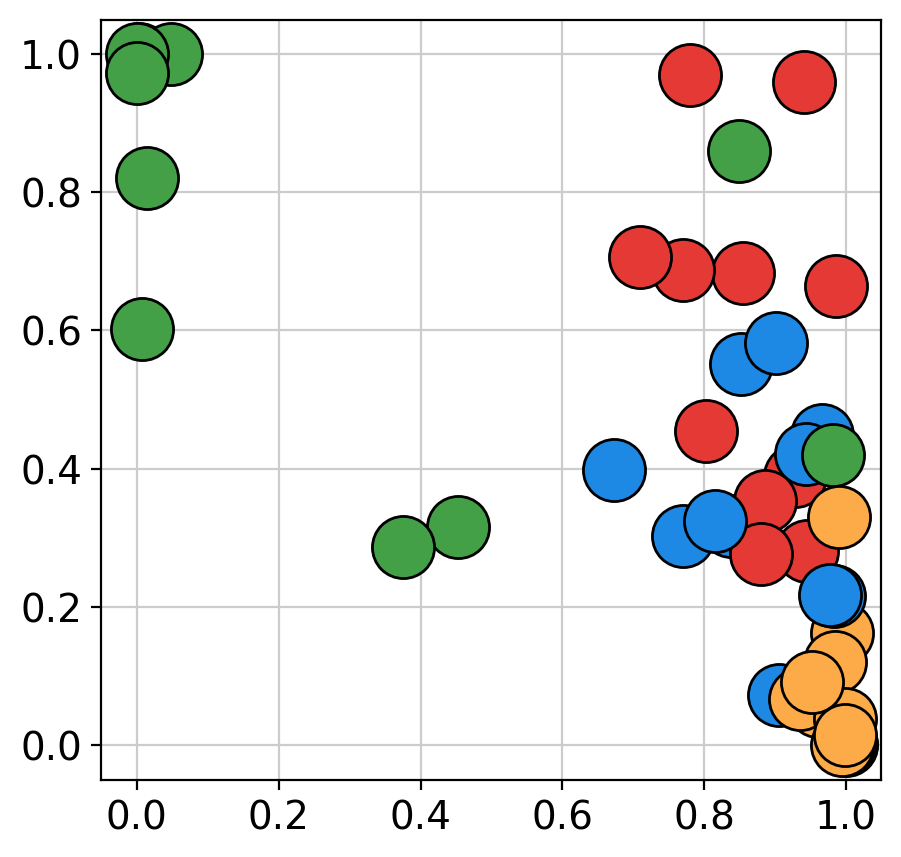

In [206]:
plt.figure(figsize=(5,5))
for prefix, result_df in result_dict.items():
    if 'Sensitivity' in result_df.index and 'Specificity' in result_df.index:
        for method in ['scMalignantFinder','PreCanCell','ikarus','Cancer-Finder']:
            plt.scatter(result_df.loc['Sensitivity',method], result_df.loc['Specificity',method],
                        color=method_color_dict[method], s=500, edgecolor='black')

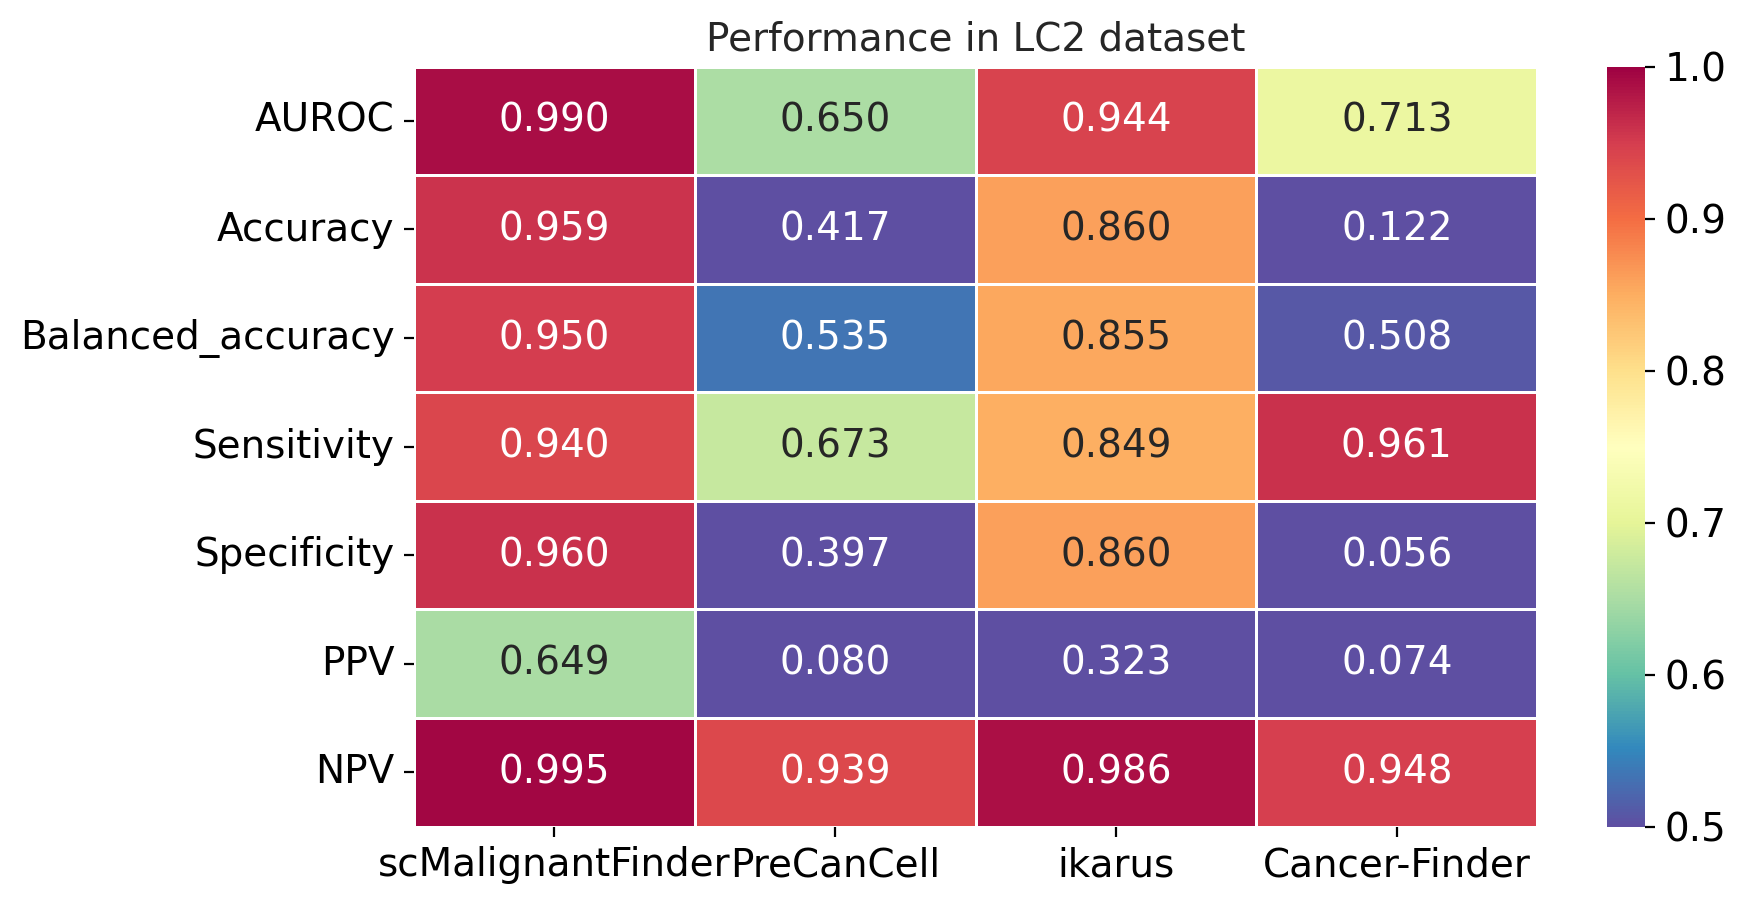

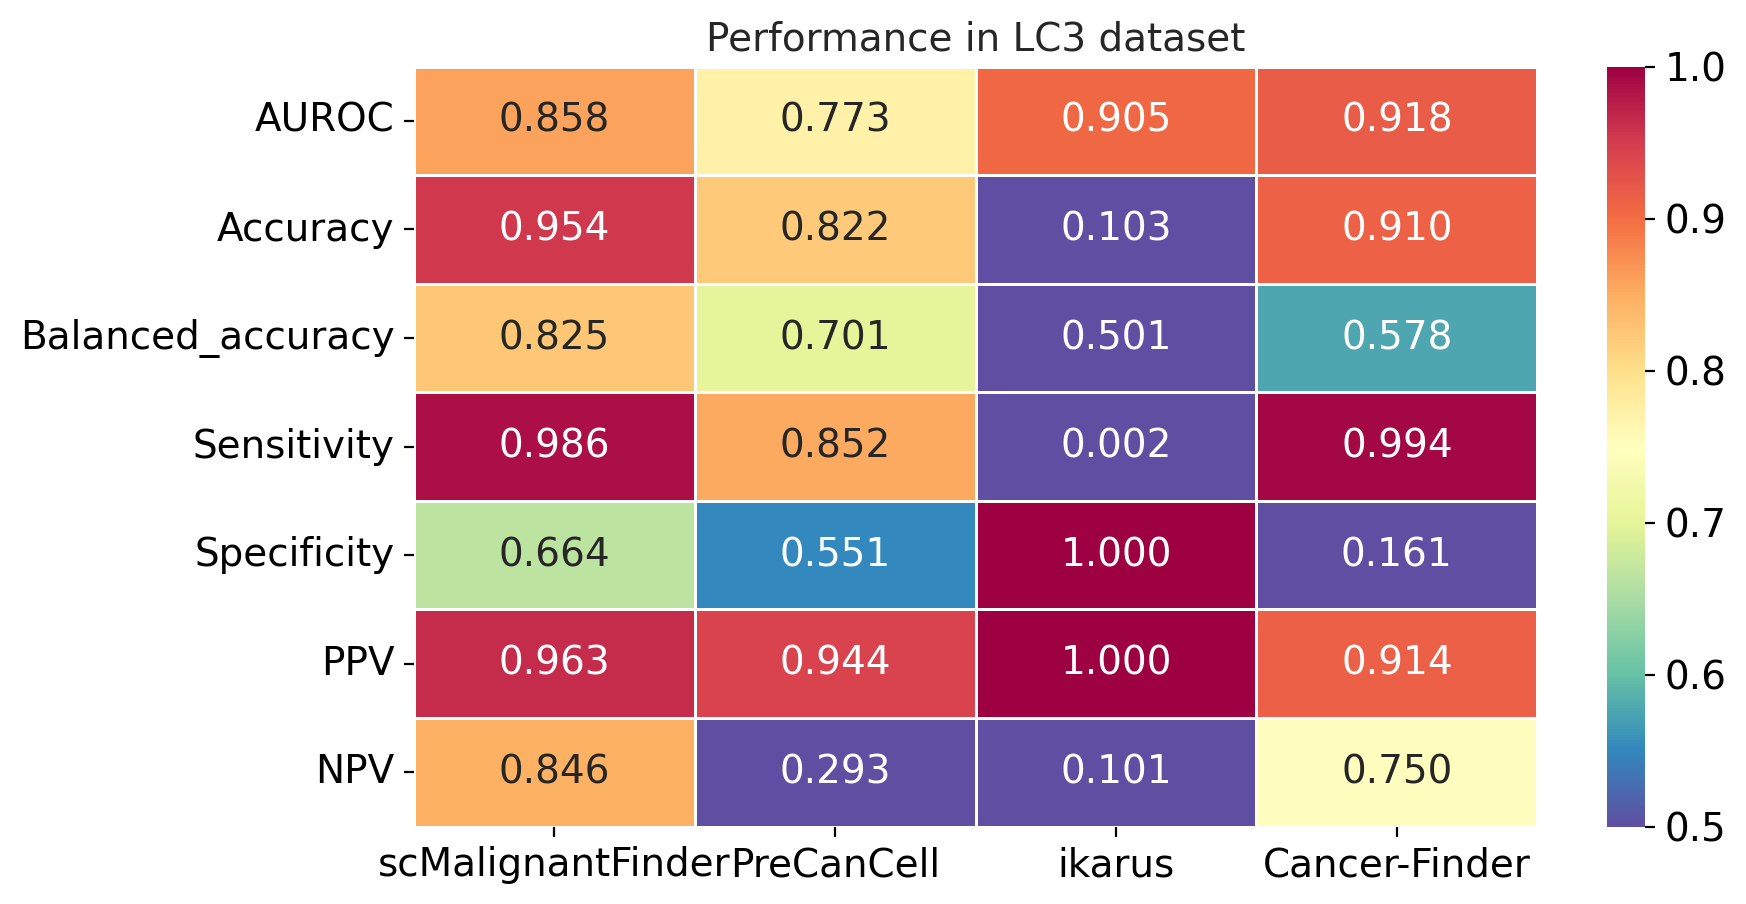

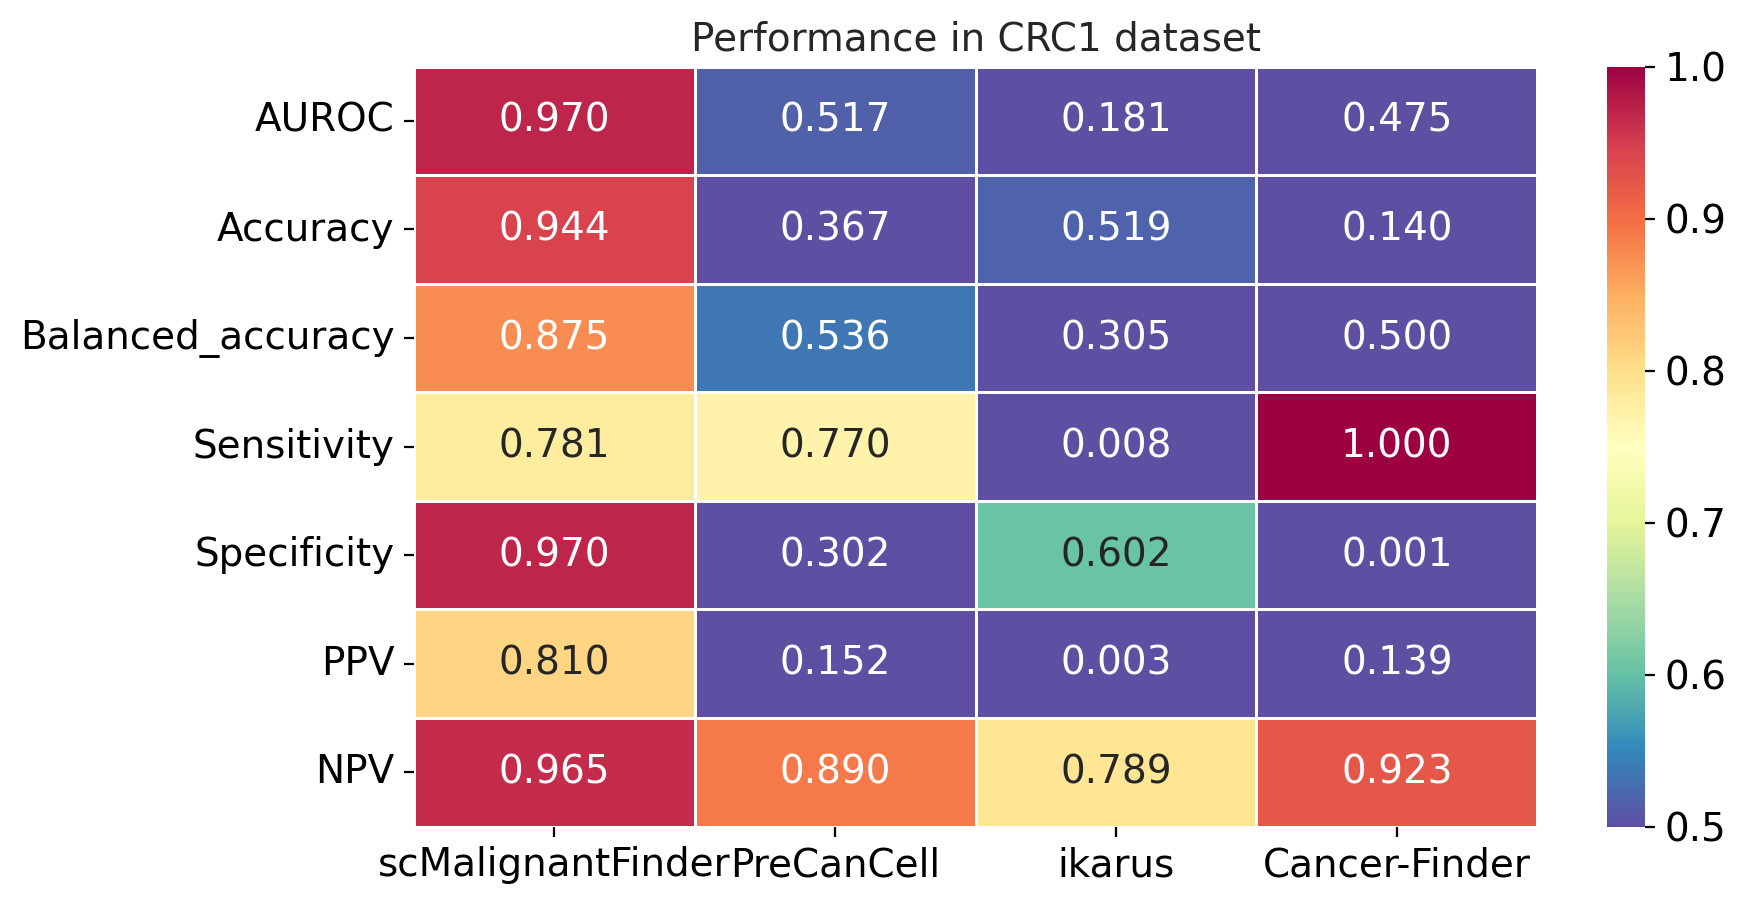

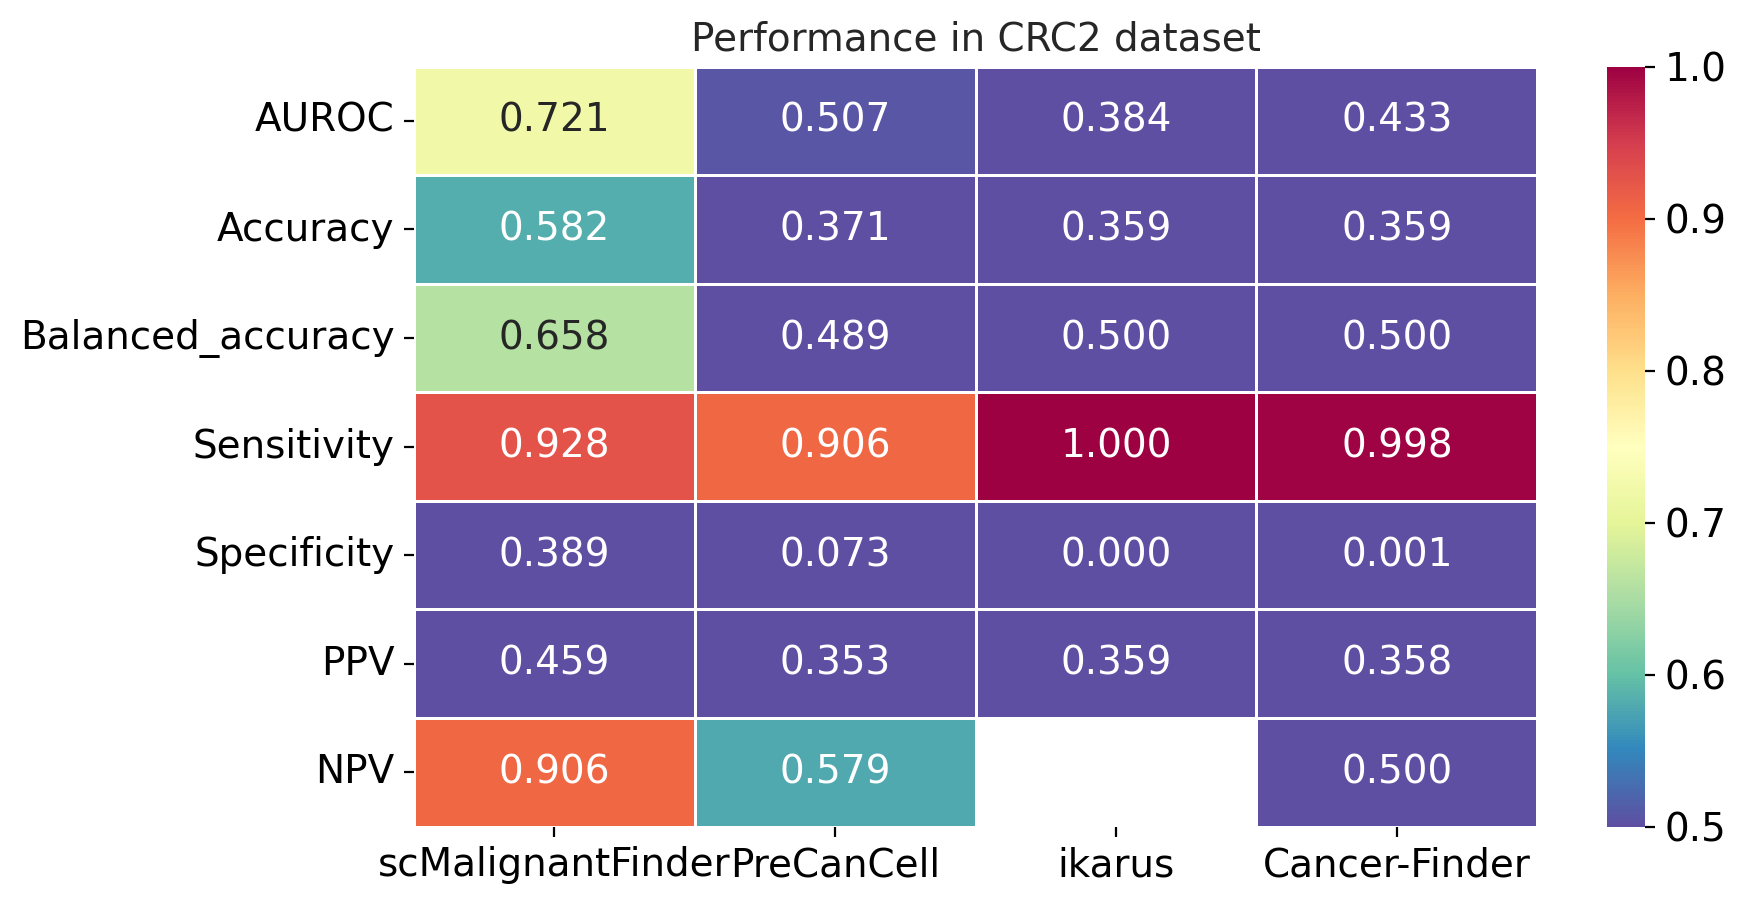

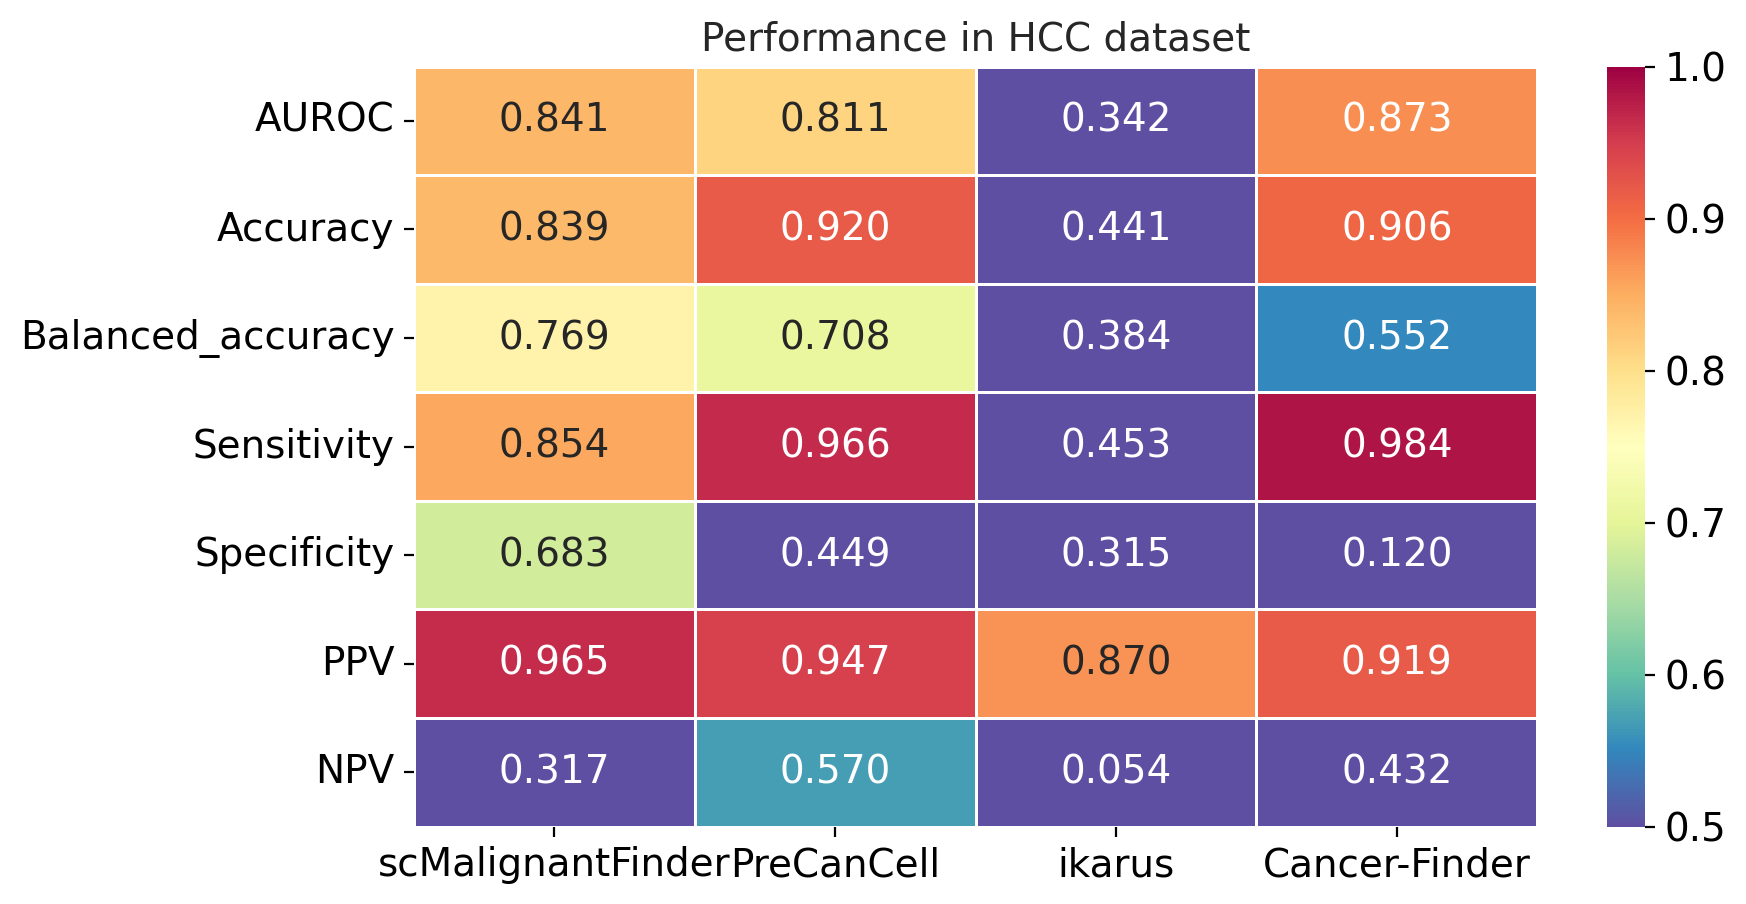

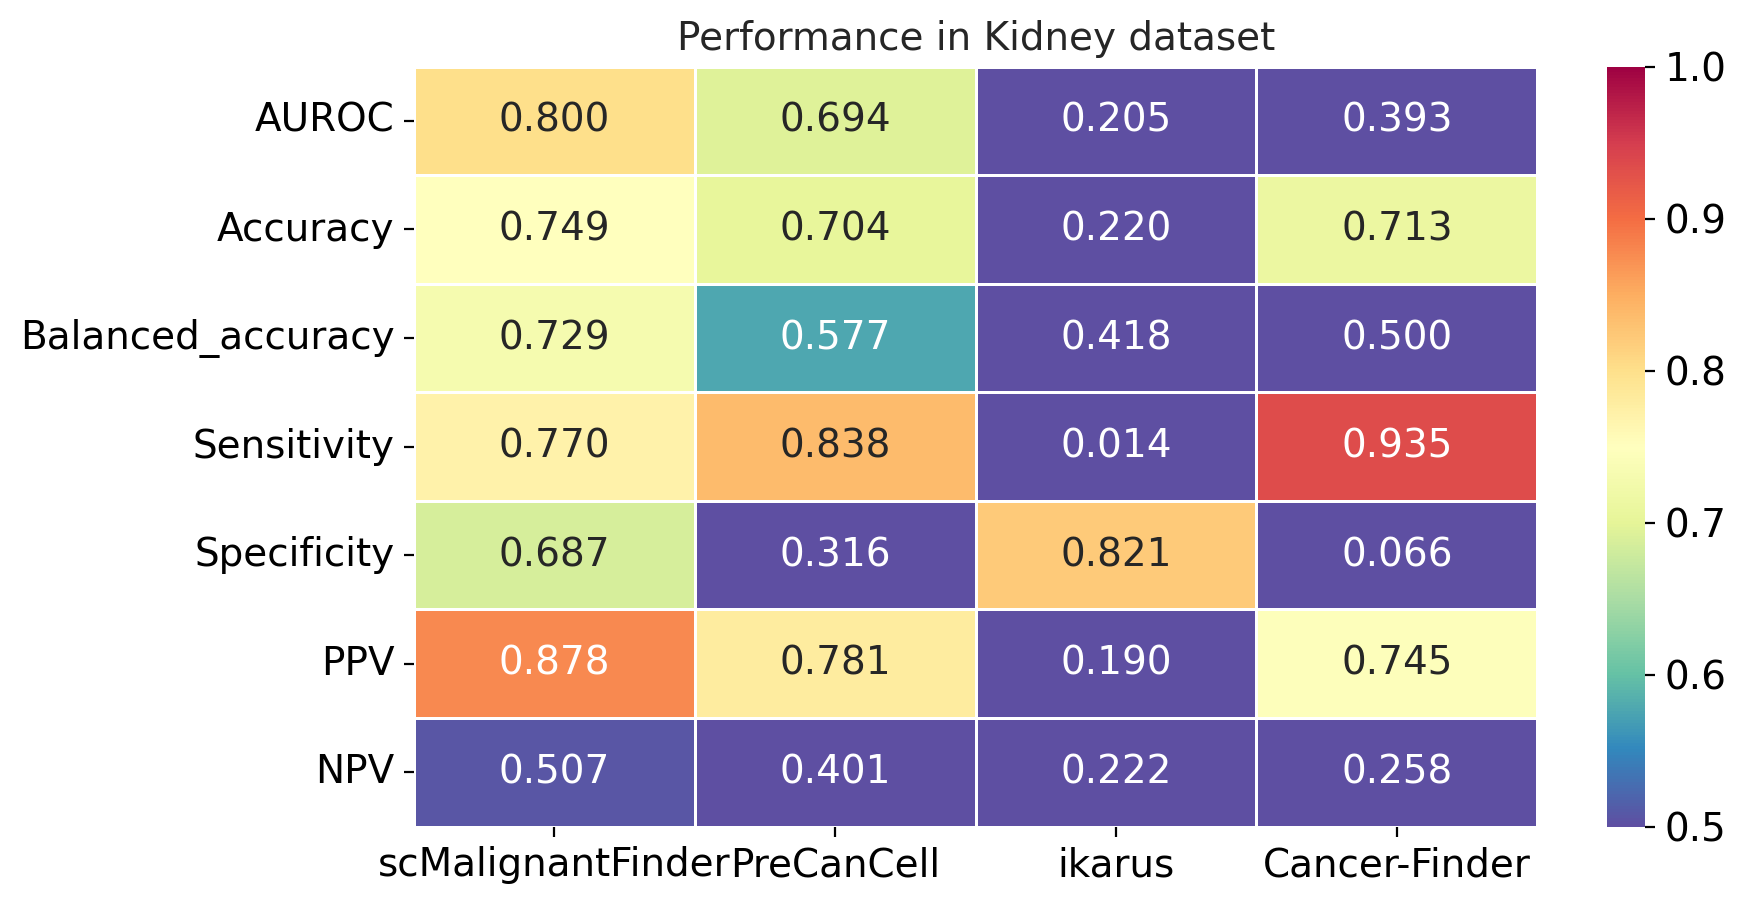

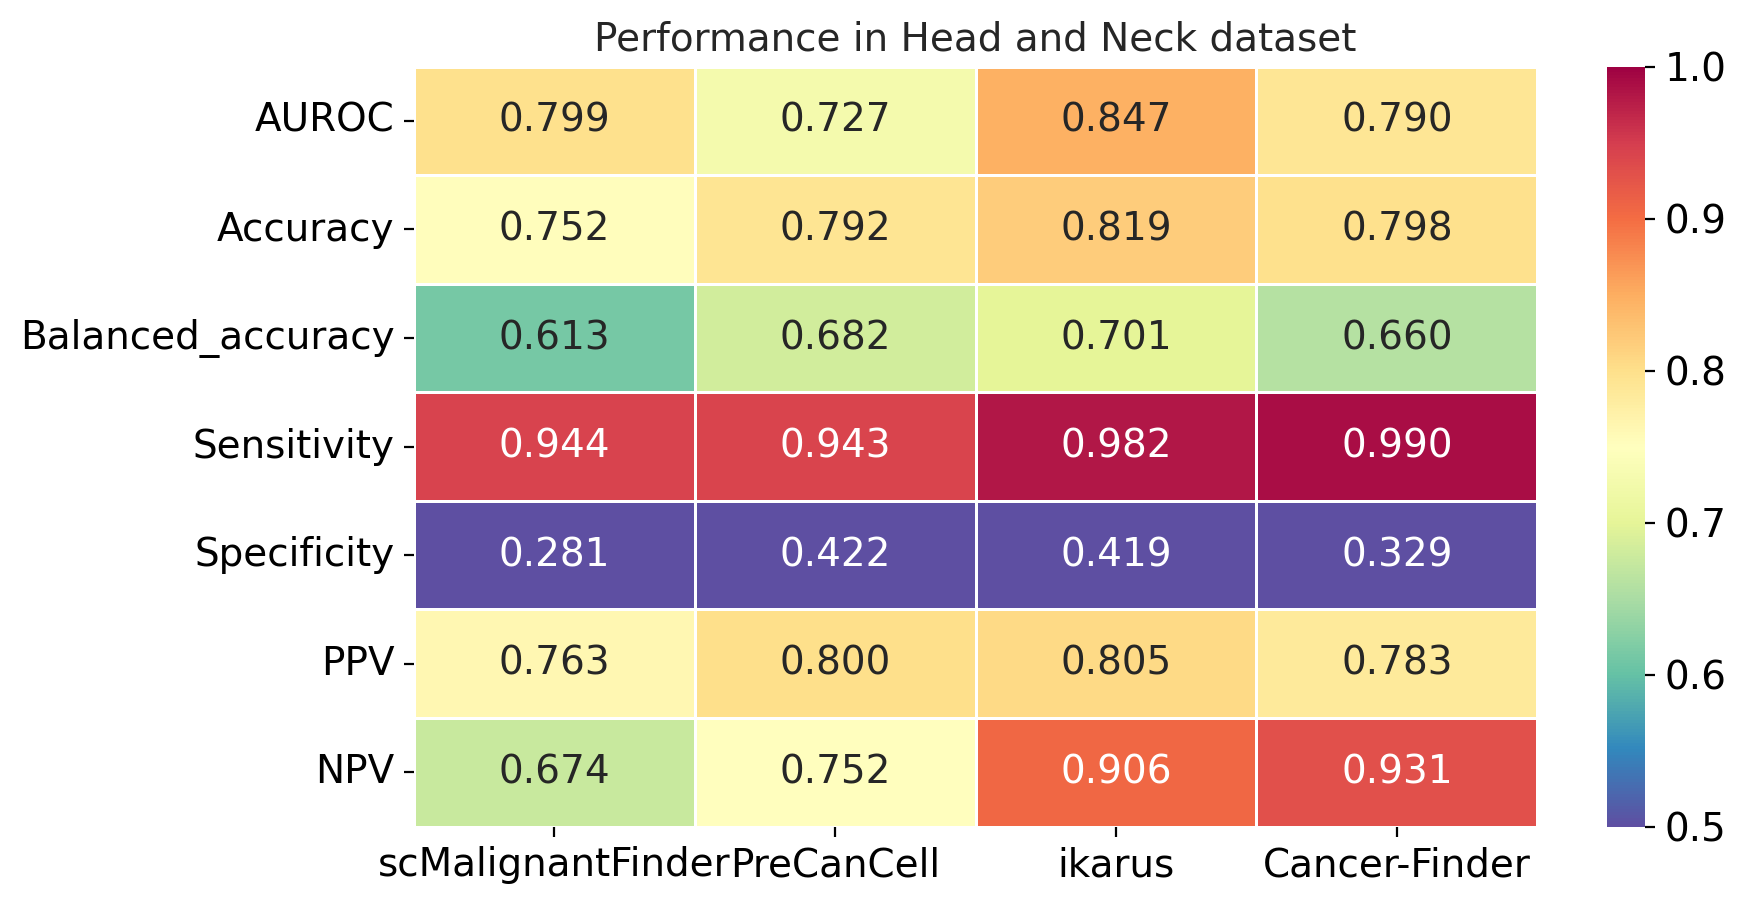

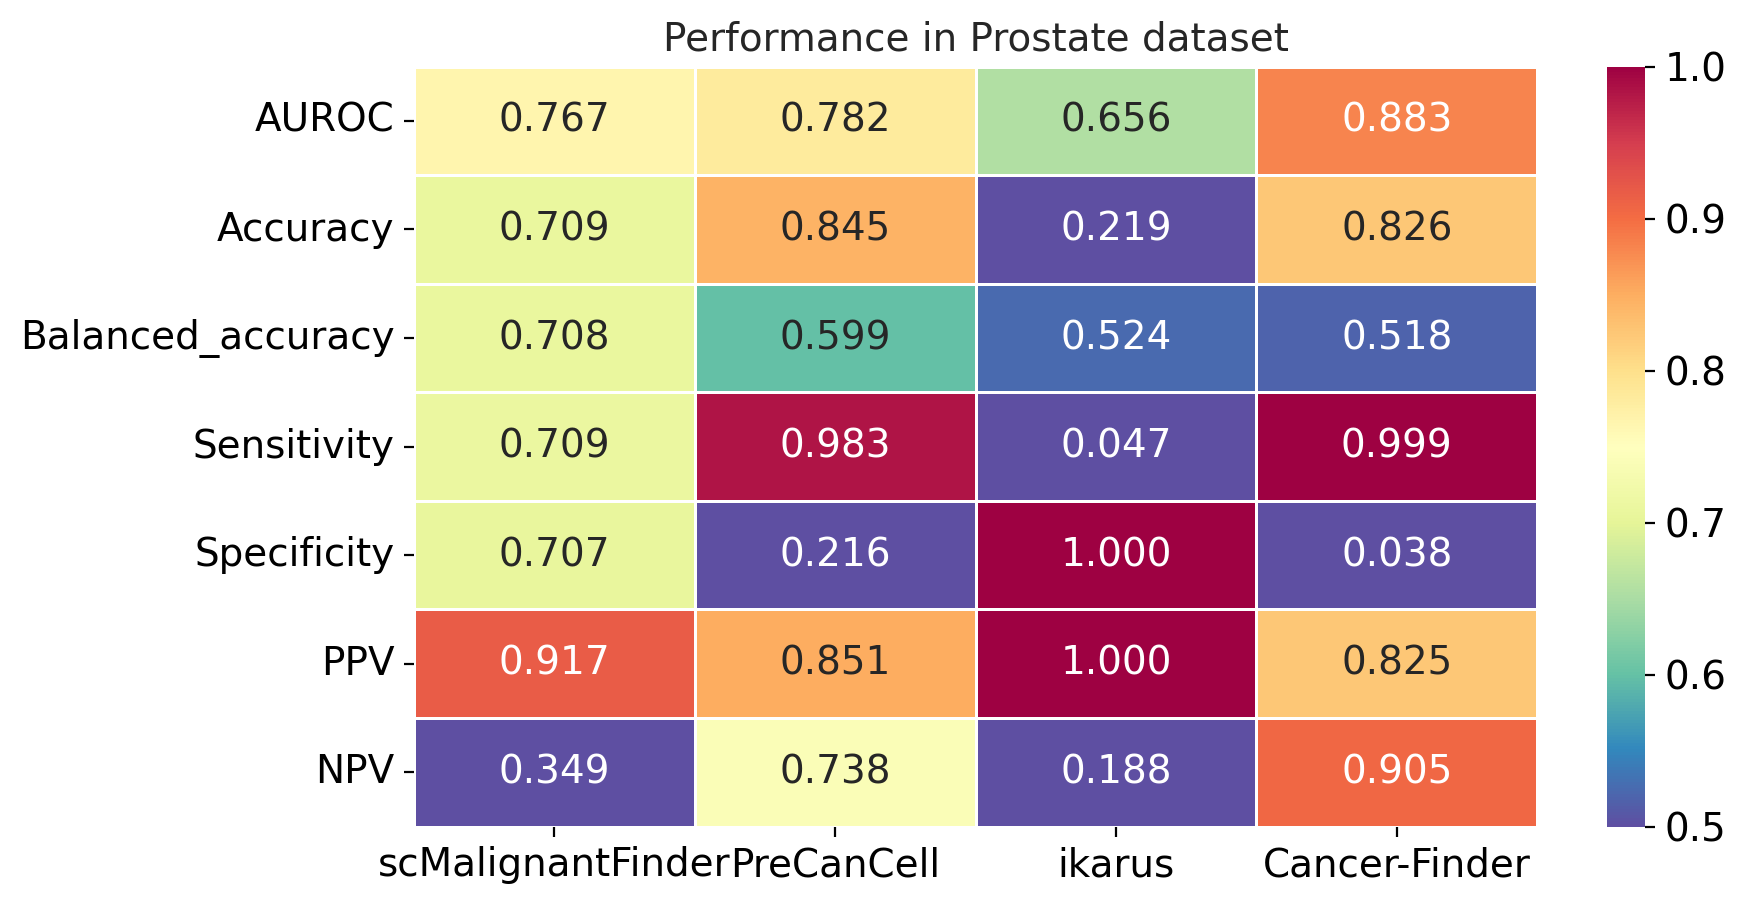

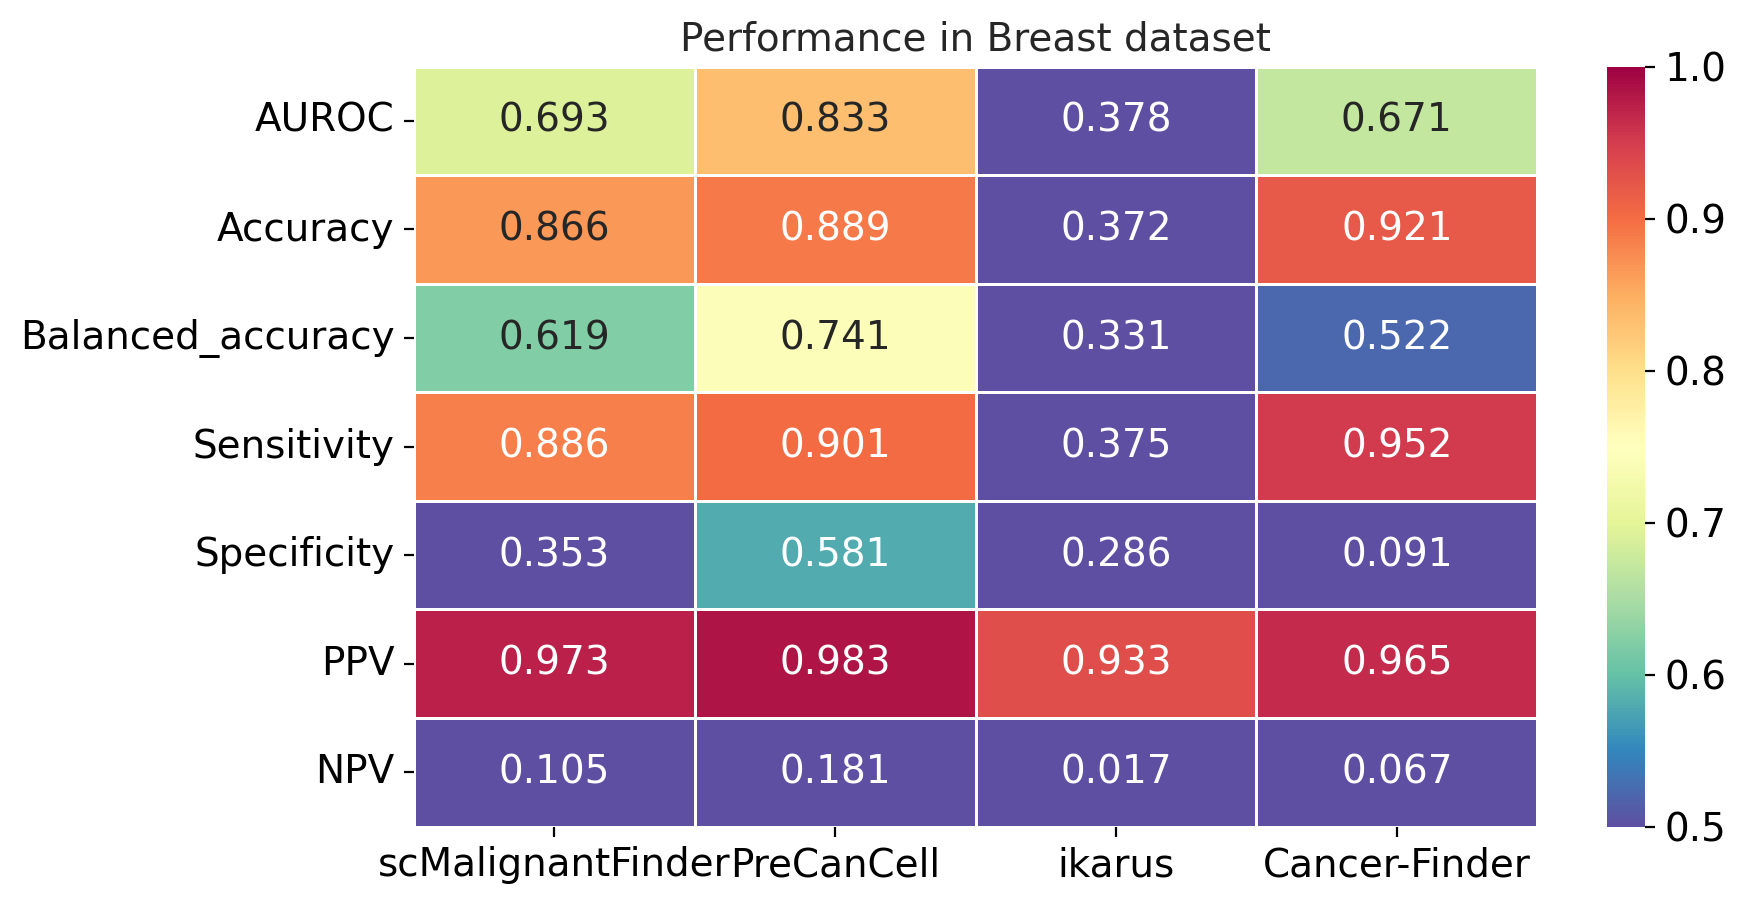

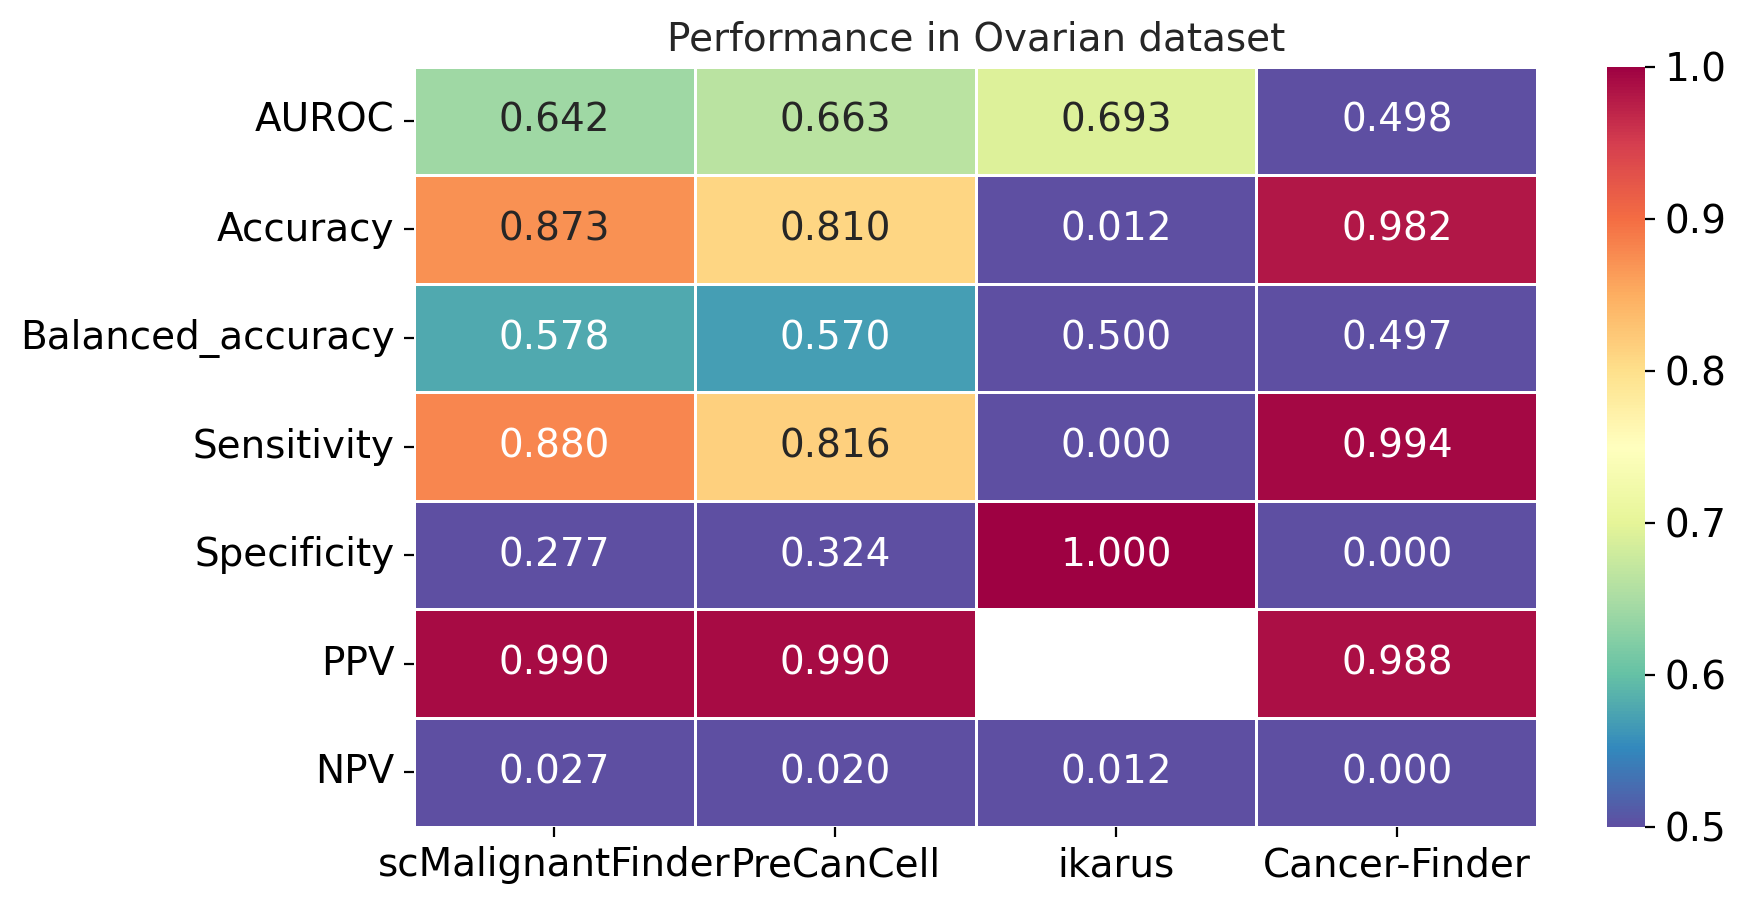

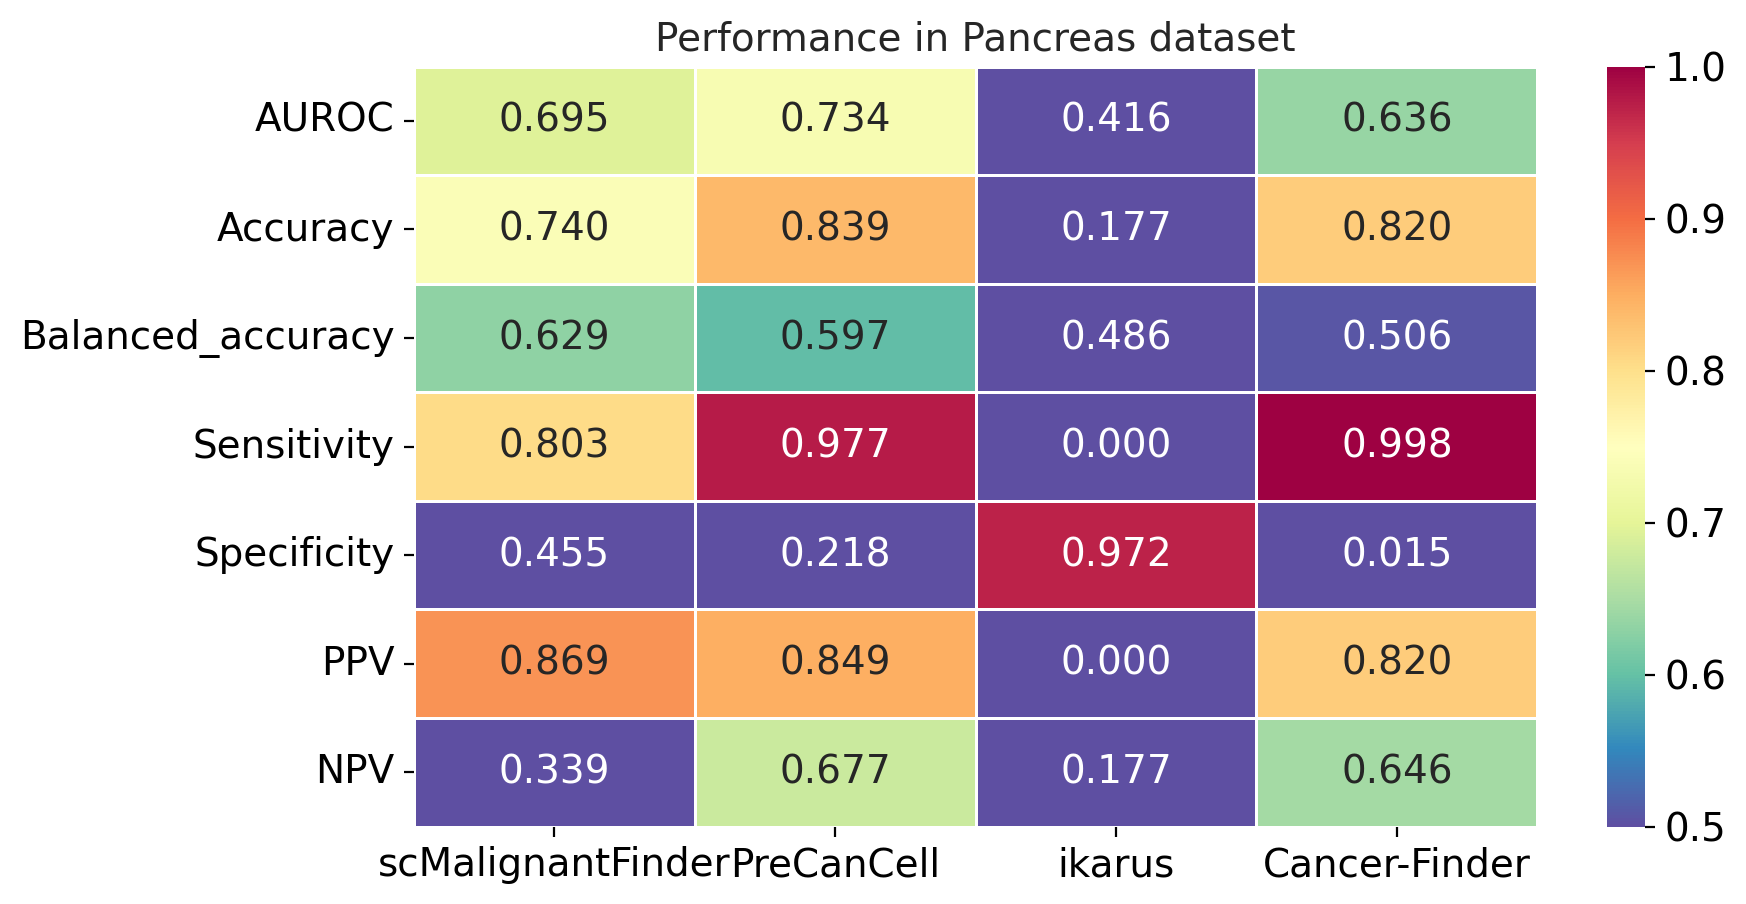

In [86]:
for prefix, result_df in result_dict.items():
    if prefix != 'cellLineTabula':
        plt.figure(figsize=(9,5))
        ax21 = plt.subplot(111)
        sns.heatmap(result_df.iloc[:,:-1], annot=True, fmt='.3f', cmap='Spectral_r', yticklabels=True, cbar=True, ax=ax21, linewidth=1, vmin=0.5, vmax=1)
        _ = ax21.set_title(f'Performance in {prefix} dataset')
        _ = plt.xticks(rotation=0)
        plt.savefig(f'./plot/metric_{prefix}.heatmap2.pdf', bbox_inches='tight')

In [166]:
for prefix in test_prefixs[1:]:
    adata = test_adata_dict[prefix]

In [170]:
test_prefixs[1:]

['LC2', 'LC3', 'CRC1', 'CRC2', 'HCC']

In [224]:
condition_dict = {
    'LC2':['disease'],'LC3':['treatment','procedure','disease'],'CRC1':['disease'],'HCC':['stage','virus']
}

In [283]:
methods = ['RandomForest (gene-based)','LogisticRegression (gene-based)','XGBoost (gene-based)',
           'RandomForest (signature-based)','LogisticRegression (signature-based)','XGBoost (signature-based)', 
           'ikarus','PreCanCell','inferCNV']

In [318]:
test_donor_metric_dict = {}
test_donor_ngene_dict = {}
test_donor_ncount_dict = {}

In [319]:
for prefix in test_prefixs[1:]:
    test_donor_metric_dict[prefix] = {}
    test_donor_ngene_dict[prefix] = {}
    test_donor_ncount_dict[prefix] = {}
    
    adata = test_adata_dict[prefix]
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    
    for donor in adata.obs[sample_prefix_dict[prefix]].unique():
        donor_cells = adata.obs[test_adata_dict[prefix].obs[sample_prefix_dict[prefix]]==donor].index.tolist()
        if adata.obs.loc[donor_cells,'Raw_annotation'].value_counts().min()>=30:
            result_df2 = pd.concat([adata.obs.loc[donor_cells,'Raw_annotation'].to_frame(), test_method_dict[prefix].loc[donor_cells]], axis=1)

            metric_df = pd.DataFrame(index=['Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV'], columns=methods)
            tumor_result_df = result_df2[result_df2['Raw_annotation']=='Tumor']
            normal_result_df = result_df2[result_df2['Raw_annotation']=='Normal']
            for method in methods:
                method_tumor_result_df = result_df2[result_df2[method]=='Tumor']
                method_normal_result_df = result_df2[result_df2[method]=='Normal']
                metric_df.loc['Accuracy',method] = result_df2[result_df2['Raw_annotation']==result_df2[method]].shape[0] / result_df2.shape[0]
                metric_df.loc['Sensitivity',method] = tumor_result_df[tumor_result_df['Raw_annotation']==tumor_result_df[method]].shape[0] / tumor_result_df.shape[0]
                metric_df.loc['Specificity',method] = normal_result_df[normal_result_df['Raw_annotation']==normal_result_df[method]].shape[0] / normal_result_df.shape[0]
                metric_df.loc['Balanced_accuracy',method] = (metric_df.loc['Sensitivity',method]+metric_df.loc['Specificity',method]) / 2
                if method_tumor_result_df.shape[0]==0:
                    metric_df.loc['PPV',method] = np.nan
                else:
                    metric_df.loc['PPV',method] = method_tumor_result_df[method_tumor_result_df['Raw_annotation']==method_tumor_result_df[method]].shape[0] / method_tumor_result_df.shape[0]
                if method_normal_result_df.shape[0]==0:
                    metric_df.loc['NPV',method] = np.nan
                else:
                    metric_df.loc['NPV',method] = method_normal_result_df[method_normal_result_df['Raw_annotation']==method_normal_result_df[method]].shape[0] / method_normal_result_df.shape[0]
            metric_df = metric_df.applymap(float)

            metric_df = metric_df.loc[:,['LogisticRegression (gene-based)','PreCanCell','ikarus']]
            metric_df = metric_df.rename(columns={'LogisticRegression (gene-based)':'scMalignantFinder'})

#             df_ls = []
#             for method in ['scMalignantFinder','PreCanCell','ikarus']:
#                 if method == 'ikarus':
#                     pred_df = pd.read_csv(f'./file/proba/{method}/test_{prefix}/prediction.csv', index_col=0)['final_pred_proba_Tumor'].to_frame()
#                     pred_df.columns = [method]
#                     pred_df.index = range(pred_df.shape[0])
#                     df_ls.append(pred_df)
#                 elif method == 'scMalignantFinder':
#                     pred_df = pd.read_csv(f'./file/proba/{method}/test_{prefix}', index_col=0)['Tumor'].to_frame()
#                     pred_df.columns = [method]
#                     pred_df.index = range(pred_df.shape[0])
#                     df_ls.append(pred_df)
#                 elif method == 'PreCanCell':
#                     pred_df = pd.read_csv(f'./file/proba/{method}/test_{prefix}.csv', index_col=0, sep='\t')['freq_cancer'].to_frame()
#                     pred_df.columns = [method]
#                     pred_df.index = range(pred_df.shape[0])
#                     df_ls.append(pred_df)

#             combine_pred_df = pd.concat(df_ls, axis=1)

#             combine_pred_df['label'] = test_adata_dict[prefix].obs['Raw_annotation'].map(label_dict).tolist()

#             auc_dict = {}
#             for method in ['scMalignantFinder','PreCanCell','ikarus']:
#                 # print(method, roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values))
#                 auc_dict[method] = roc_auc_score(combine_pred_df['label'].values, combine_pred_df[method].values)

#             tmp_metric_df = metric_df.T

#             tmp_metric_df['AUROC'] = tmp_metric_df.index.map(auc_dict)
#             metric_df = tmp_metric_df.T.loc[['AUROC','Accuracy','Balanced_accuracy','Sensitivity','Specificity','PPV','NPV']]
            
            test_donor_metric_dict[prefix][donor] = metric_df
            test_donor_ngene_dict[prefix][donor] = adata.obs.loc[donor_cells,'n_genes_by_counts'].median()
            test_donor_ncount_dict[prefix][donor] = adata.obs.loc[donor_cells,'total_counts'].median()

/tmp/ipykernel_76305/2764852243.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_76305/2764852243.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_76305/2764852243.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_76305/2764852243.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_76305/2764852243.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_76305/2764852243.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  metric_df = metric_df.applymap(float)
/tmp/ipykernel_76305/2764852243.py

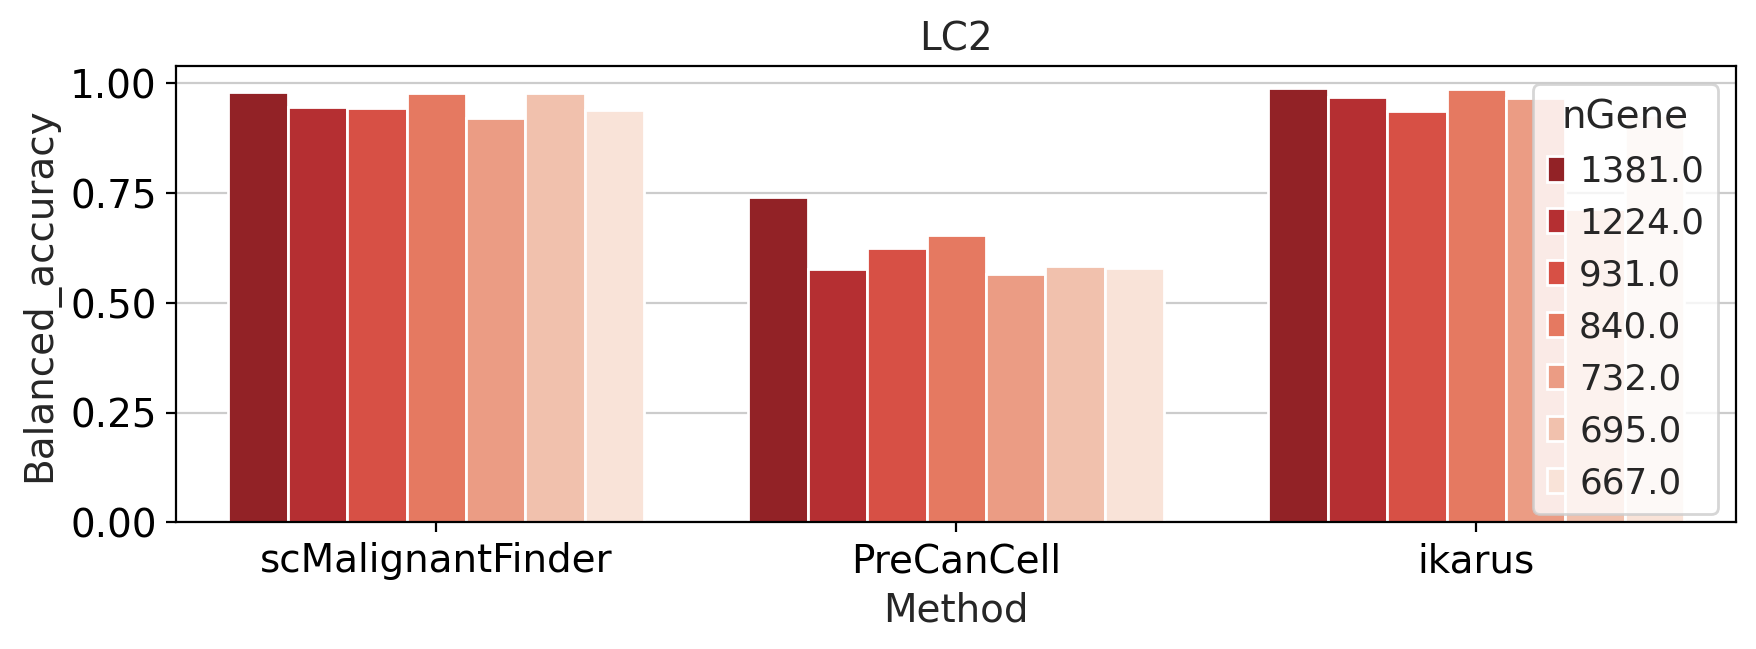

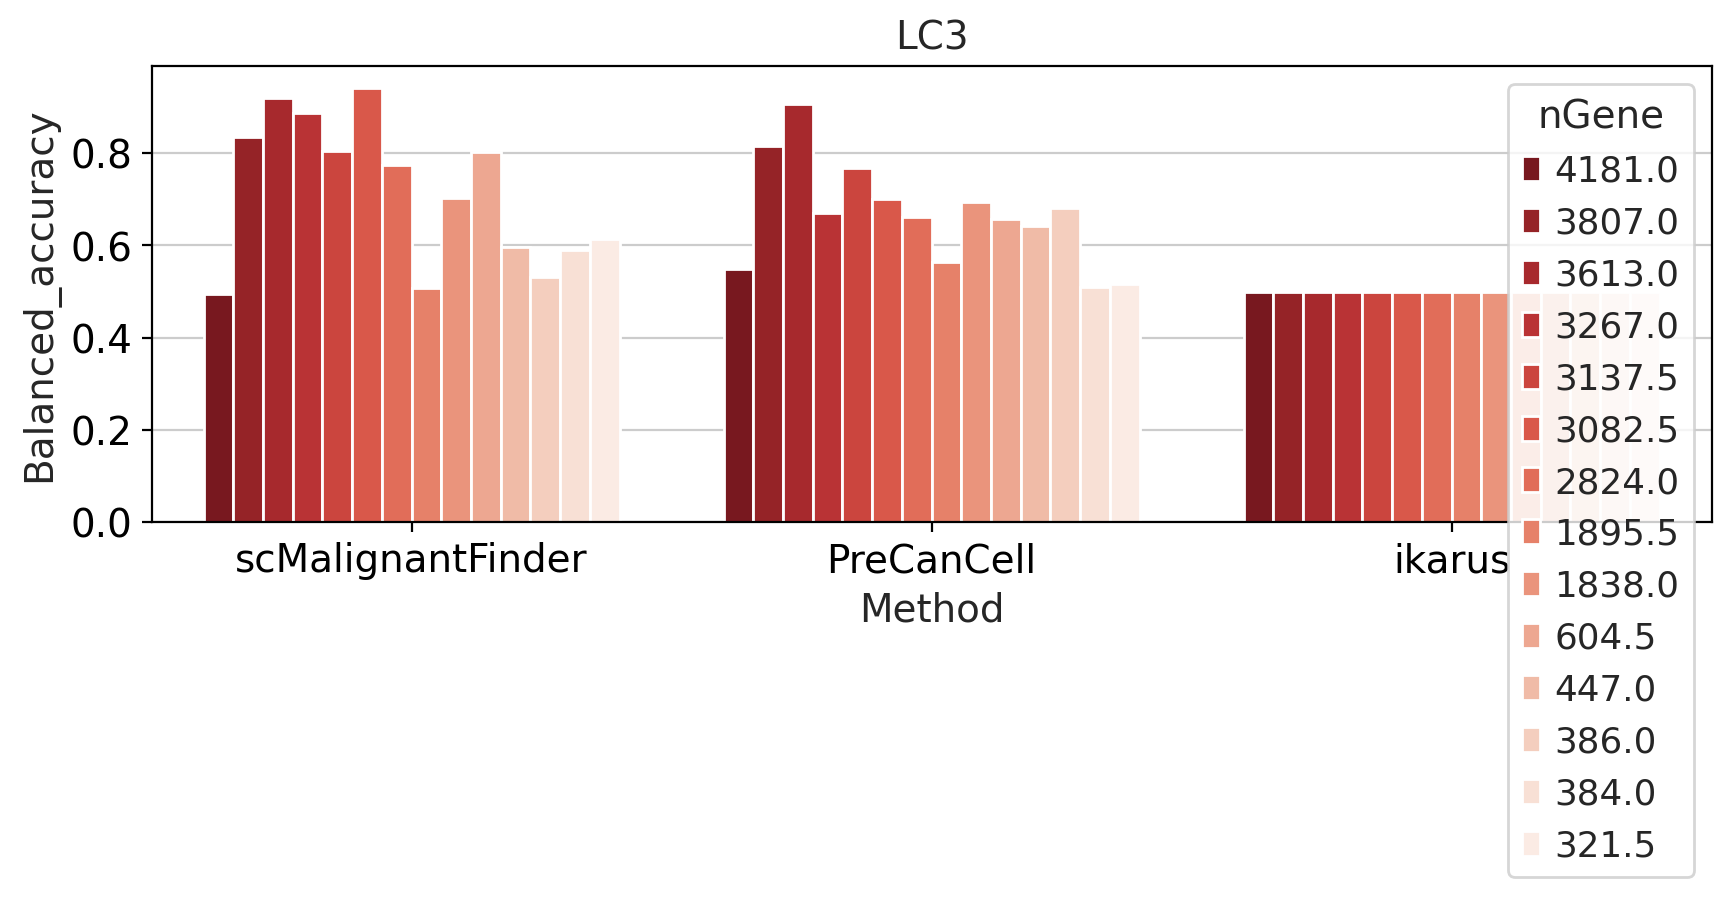

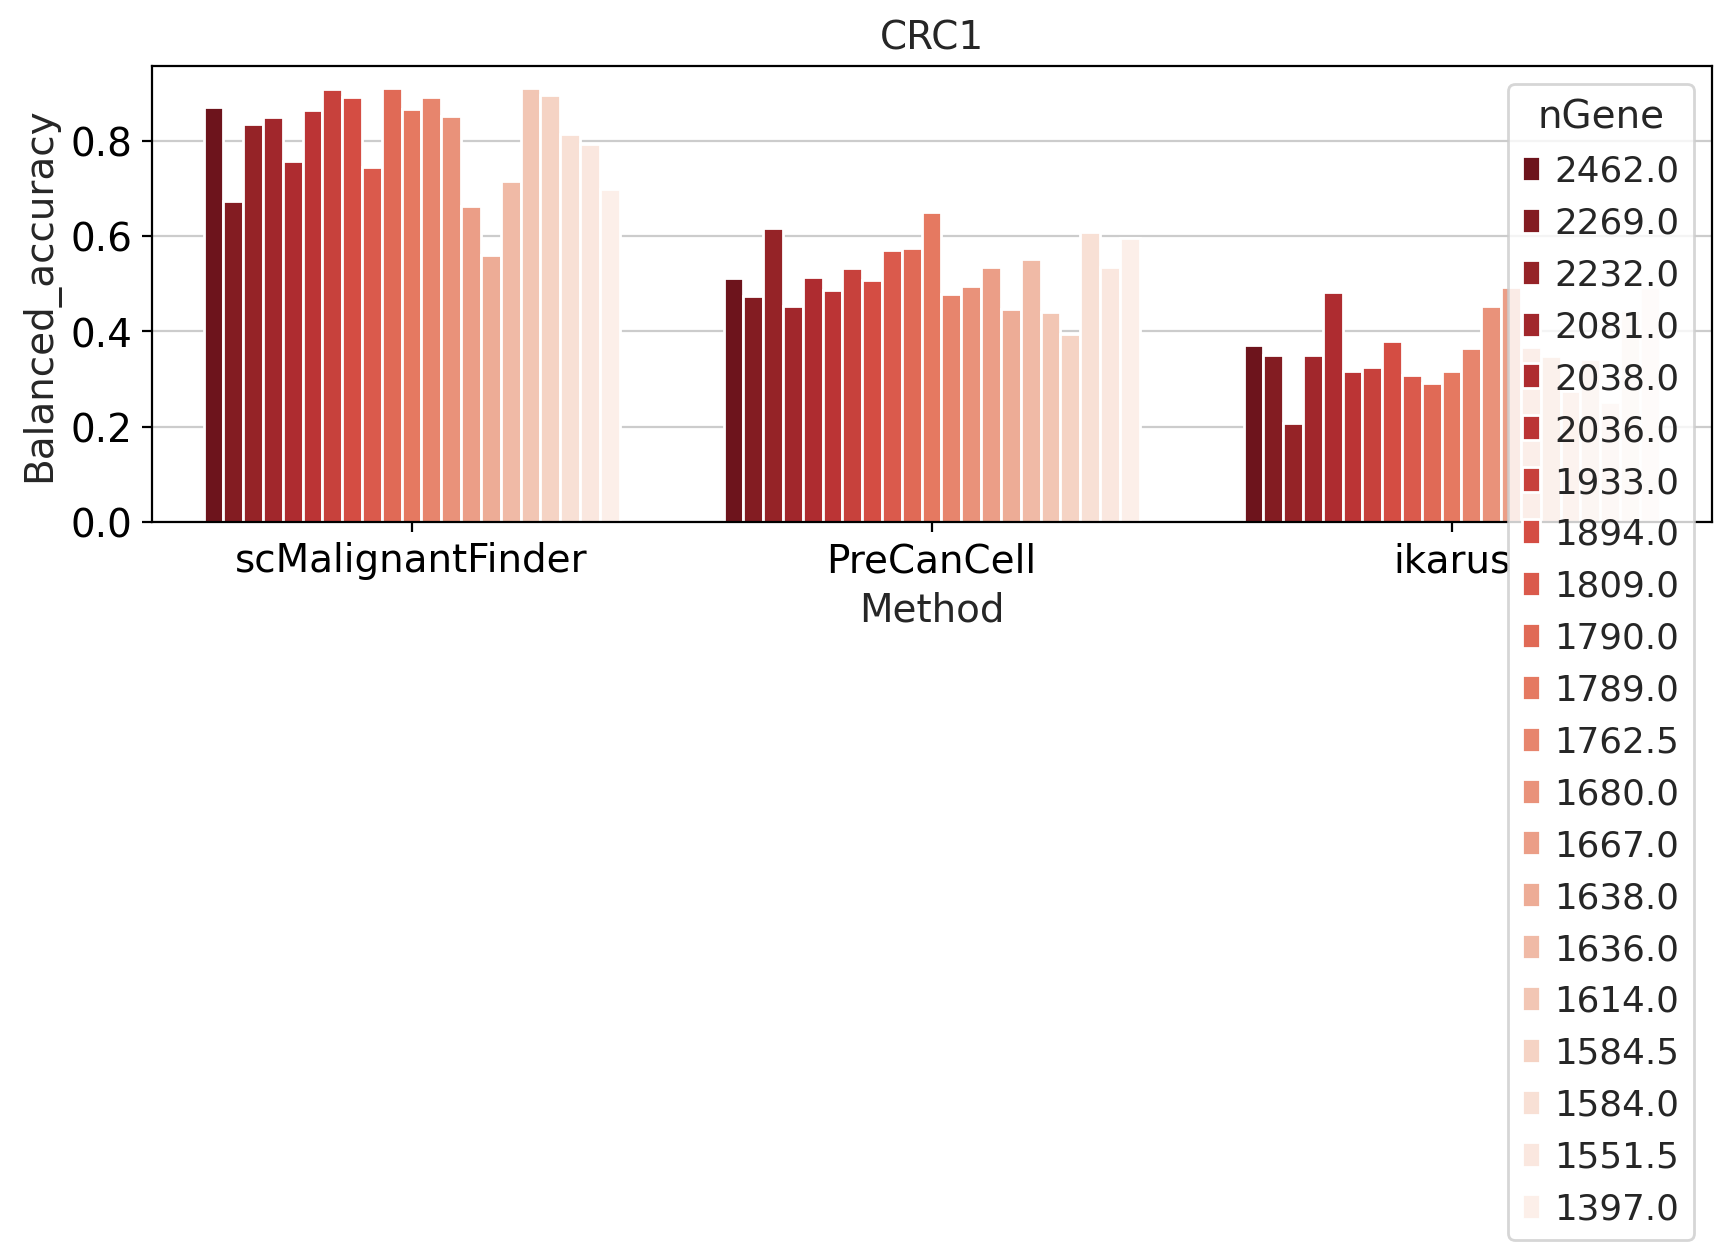

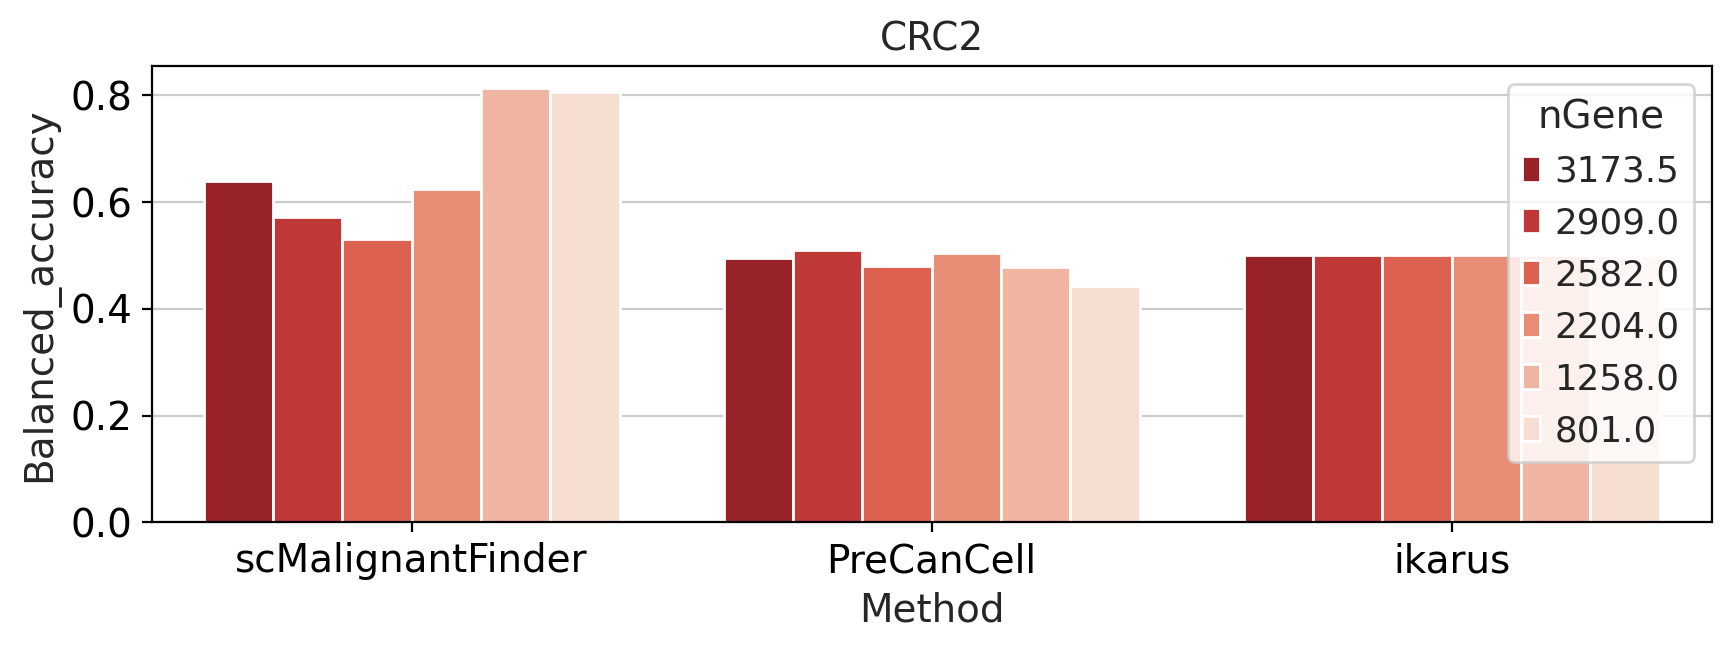

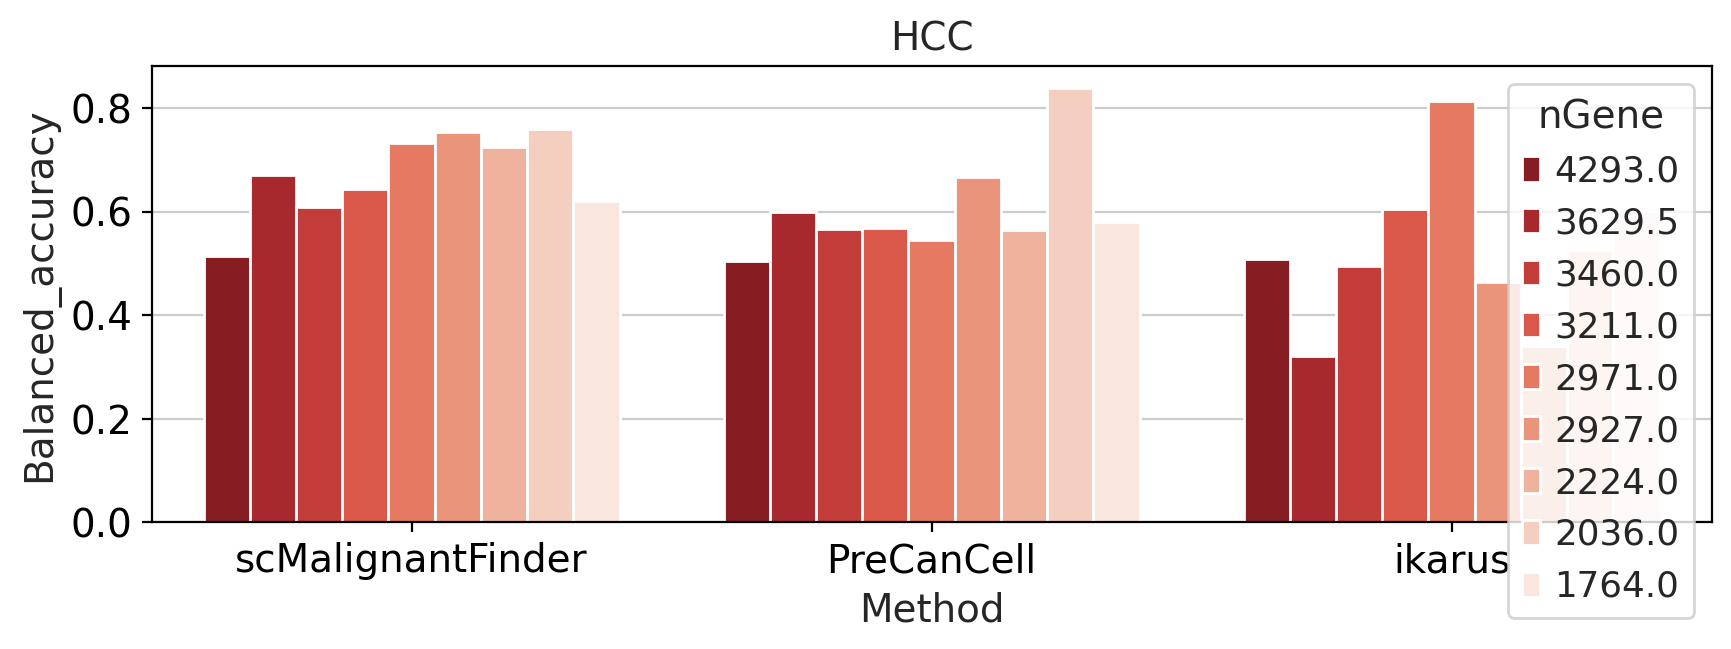

In [369]:
for prefix in test_prefixs[1:]:
    sorted_dict = sorted(test_donor_ngene_dict[prefix].items(), key=lambda x: x[1], reverse=True)
    order_donor_ls = [key for key, value in sorted_dict]
    order_ngene_ls = [test_donor_ngene_dict[prefix][x] for x in order_donor_ls]

    metric = 'Balanced_accuracy'

    tmp_donor_ls = []
    tmp_ngene_ls = []
    tmp_ncount_ls = []
    tmp_method_ls = []
    tmp_metric_ls = []
    for donor in order_donor_ls:
        tmp_donor_ls.extend([donor]*3)
        tmp_ngene_ls.extend([test_donor_ngene_dict[prefix][donor]]*3)
        tmp_ncount_ls.extend([test_donor_ncount_dict[prefix][donor]]*3)
        tmp_method_ls.extend(test_donor_metric_dict[prefix][donor].columns)
        tmp_metric_ls.extend(test_donor_metric_dict[prefix][donor].loc[metric].tolist())

    plot_df = pd.DataFrame({'Donor':tmp_donor_ls, 'nGene':tmp_ngene_ls, 'nCount':tmp_ncount_ls, 'Method':tmp_method_ls, 'Metric':tmp_metric_ls})
    
    plt.figure(figsize=(10,3))
    _ = sns.barplot(x='Method', y='Metric', hue='nGene', data=plot_df, hue_order=order_ngene_ls, palette='Reds_r')
    _ = plt.ylabel(metric)
    _ = plt.title(prefix)

In [370]:
method = 'scMalignantFinder'

LC2 0.5357142857142858 0.21521745567801273
LC3 0.4021978021978022 0.15397442954140356
CRC1 0.1155844155844156 0.6178368603191975
CRC2 -0.5428571428571429 0.26570262390670557
HCC -0.5333333333333333 0.13922686754397814


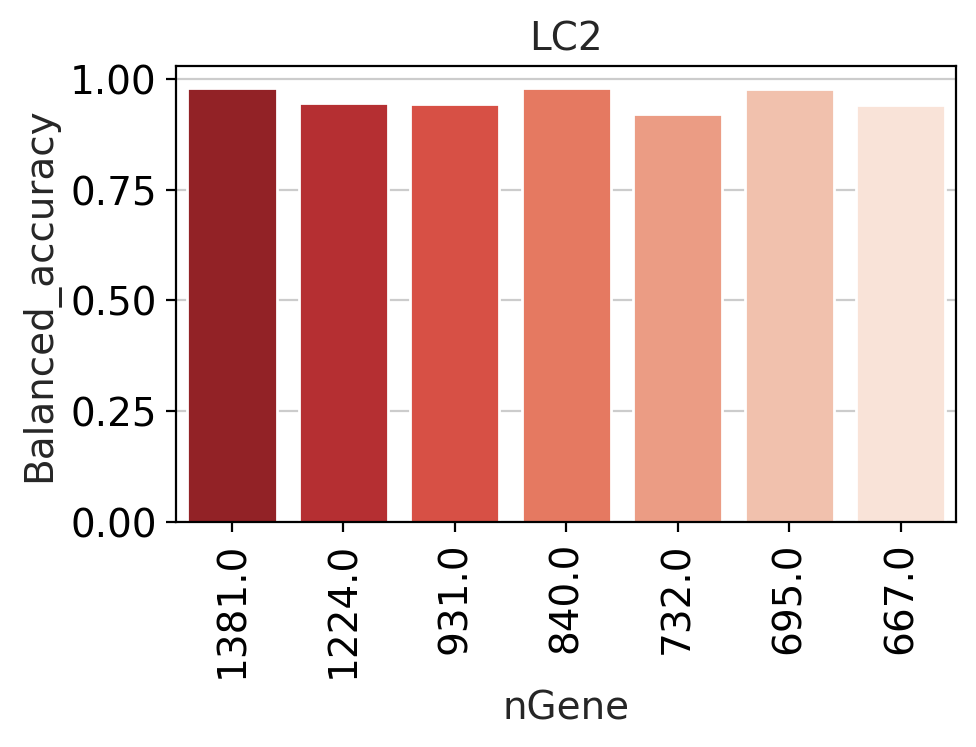

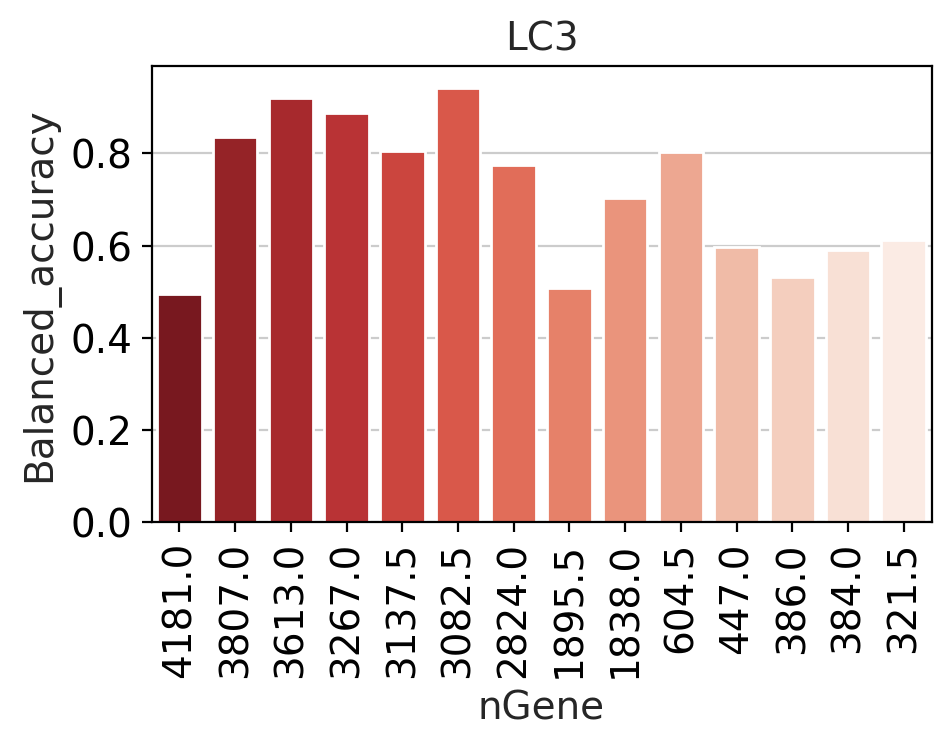

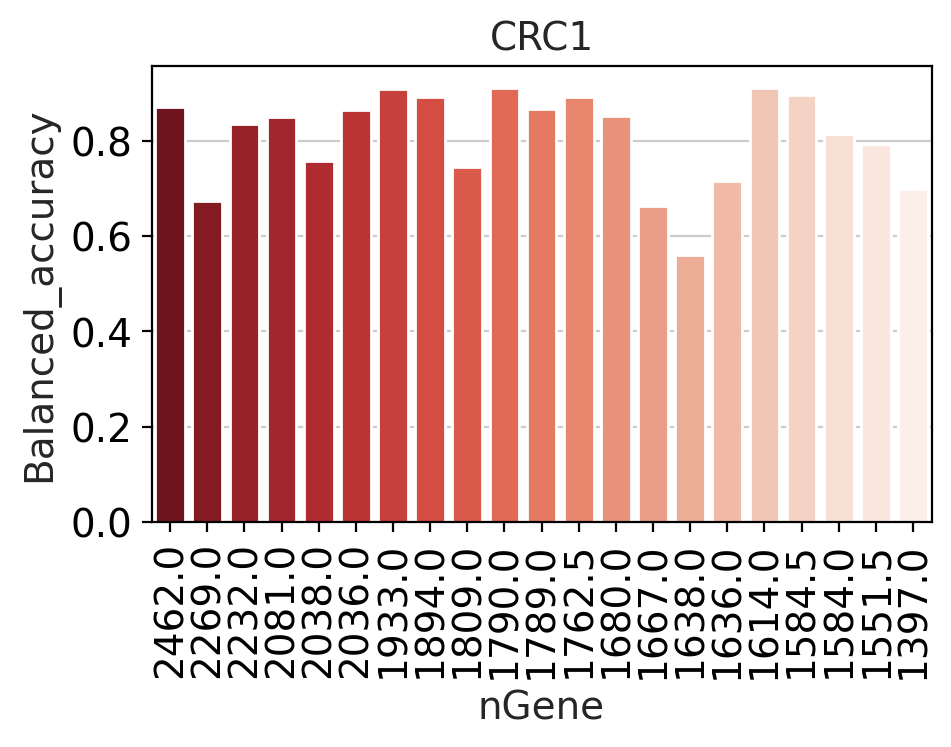

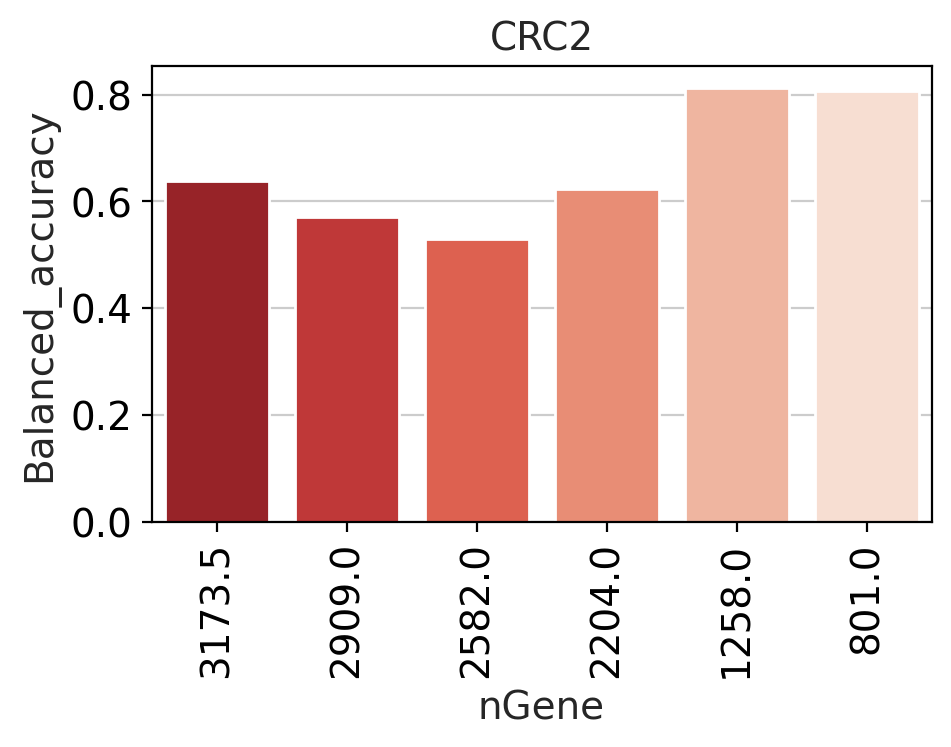

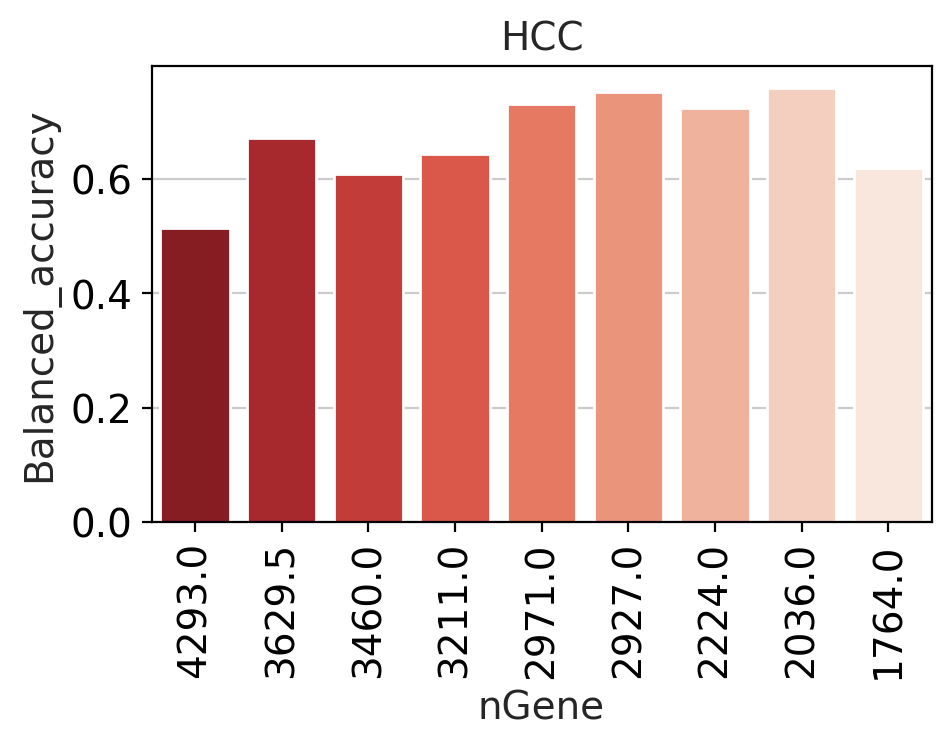

In [387]:
for prefix in test_prefixs[1:]:
    sorted_dict = sorted(test_donor_ngene_dict[prefix].items(), key=lambda x: x[1], reverse=True)
    order_donor_ls = [key for key, value in sorted_dict]
    order_ngene_ls = [test_donor_ngene_dict[prefix][x] for x in order_donor_ls]

    metric = 'Balanced_accuracy'

    tmp_donor_ls = []
    tmp_ngene_ls = []
    tmp_ncount_ls = []
    tmp_method_ls = []
    tmp_metric_ls = []
    for donor in order_donor_ls:
        tmp_donor_ls.extend([donor]*3)
        tmp_ngene_ls.extend([test_donor_ngene_dict[prefix][donor]]*3)
        tmp_ncount_ls.extend([test_donor_ncount_dict[prefix][donor]]*3)
        tmp_method_ls.extend(test_donor_metric_dict[prefix][donor].columns)
        tmp_metric_ls.extend(test_donor_metric_dict[prefix][donor].loc[metric].tolist())

    plot_df = pd.DataFrame({'Donor':tmp_donor_ls, 'nGene':tmp_ngene_ls, 'nCount':tmp_ncount_ls, 'Method':tmp_method_ls, 'Metric':tmp_metric_ls})
    sel_plot_df = plot_df[plot_df['Method']==method]
    corr, pvalue = spearmanr(sel_plot_df['nGene'], sel_plot_df['Metric'])
    print(prefix, corr, pvalue)
    
    plt.figure(figsize=(5,3))
    _ = sns.barplot(x='nGene', y='Metric', data=sel_plot_df, order=order_ngene_ls, palette='Reds_r')
    _ = plt.ylabel(metric)
    _ = plt.title(prefix)
    _ = plt.xticks(rotation=90)
    plt.savefig(f'./plot/{metric}_{prefix}.{method}.nGene.barplot.pdf', bbox_inches='tight')

In [404]:
for prefix in test_prefixs[1:]:
    sorted_dict = sorted(test_donor_ngene_dict[prefix].items(), key=lambda x: x[1], reverse=True)
    order_donor_ls = [key for key, value in sorted_dict]
    order_ngene_ls = [test_donor_ngene_dict[prefix][x] for x in order_donor_ls]

    metric = 'Balanced_accuracy'

    tmp_donor_ls = []
    tmp_ngene_ls = []
    tmp_ncount_ls = []
    tmp_method_ls = []
    tmp_metric_ls = []
    for donor in order_donor_ls:
        tmp_donor_ls.extend([donor]*3)
        tmp_ngene_ls.extend([test_donor_ngene_dict[prefix][donor]]*3)
        tmp_ncount_ls.extend([test_donor_ncount_dict[prefix][donor]]*3)
        tmp_method_ls.extend(test_donor_metric_dict[prefix][donor].columns)
        tmp_metric_ls.extend(test_donor_metric_dict[prefix][donor].loc[metric].tolist())

    plot_df = pd.DataFrame({'Donor':tmp_donor_ls, 'nGene':tmp_ngene_ls, 'nCount':tmp_ncount_ls, 'Method':tmp_method_ls, 'Metric':tmp_metric_ls})
    sel_plot_df = plot_df[plot_df['Method']==method]
    sel_plot_df['Group'] = 'low nGene'
    sel_plot_df.loc[sel_plot_df.index[:int(sel_plot_df.shape[0]/2)],'Group'] = 'high nGene'
    pvalue = ranksums(sel_plot_df[sel_plot_df['Group']=='low nGene']['Metric'], sel_plot_df[sel_plot_df['Group']=='high nGene']['Metric'])[1]
    print(prefix, pvalue)

LC2 0.4795001221869535
LC3 0.0350056820770933
CRC1 0.4385780260809998
CRC2 0.12663045794761718
HCC 0.050043521248705106


/tmp/ipykernel_76305/2294494252.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_plot_df['Group'] = 'low nGene'
/tmp/ipykernel_76305/2294494252.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_plot_df['Group'] = 'low nGene'
/tmp/ipykernel_76305/2294494252.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [407]:
meta1_df

,tissue_in_publication,assay_ontology_term_id,donor_id,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,...,development_stage_ontology_term_id,self_reported_ethnicity_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
AACAGGGCATGTGCTA_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,NaN,14151.0,3404,hepatocyte,Hepatocyte,True,epithelial,...,HsapDv:0000161,HANCESTRO:0005,hepatocyte,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
AATGAAGTCTAAGGAA_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,NaN,10303.0,2863,hepatocyte,Hepatocyte,True,epithelial,...,HsapDv:0000161,HANCESTRO:0005,hepatocyte,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
ACAGAAAAGCTGTCCG_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,NaN,9391.0,2738,hepatocyte,Hepatocyte,True,epithelial,...,HsapDv:0000161,HANCESTRO:0005,hepatocyte,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
ACGATGTTCGACTCCT_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,NaN,4634.0,1634,hepatocyte,Hepatocyte,True,epithelial,...,HsapDv:0000161,HANCESTRO:0005,hepatocyte,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
ACGTTCCAGAACCCGA_TSP6_Liver_NA_10X_1_1,Liver,EFO:0009922,TSP6,NaN,33370.0,6590,intrahepatic cholangiocyte,BECS,True,epithelial,...,HsapDv:0000161,HANCESTRO:0005,intrahepatic cholangiocyte,10x 3' v3,normal,Homo sapiens,male,liver,European,67-year-old human stage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGACAGTAGATGGCGT_TSP2_Vasculature_Aorta_10X_1_2,Vasculature,EFO:0009922,TSP2,aorta,10354.0,2456,epithelial cell,epithelial cell,True,epithelial,...,HsapDv:0000155,HANCESTRO:0016,epithelial cell,10x 3' v3,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage
TGTTGGATCGACATCA_TSP2_Vasculature_Aorta_10X_1_2,Vasculature,EFO:0009922,TSP2,aorta,15677.0,3234,epithelial cell,epithelial cell,True,epithelial,...,HsapDv:0000155,HANCESTRO:0016,epithelial cell,10x 3' v3,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage
TTGGATGGTGGCTACC_TSP2_Vasculature_Aorta_10X_1_2,Vasculature,EFO:0009922,TSP2,aorta,18638.0,3368,epithelial cell,epithelial cell,True,epithelial,...,HsapDv:0000155,HANCESTRO:0016,epithelial cell,10x 3' v3,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage
CTTGATTTCTTGCAAG_TSP2_Vasculature_Aorta_10X_2_2,Vasculature,EFO:0009922,TSP2,aorta,36555.0,5102,epithelial cell,epithelial cell,True,epithelial,...,HsapDv:0000155,HANCESTRO:0016,epithelial cell,10x 3' v3,normal,Homo sapiens,female,aorta,African American or Afro-Caribbean,61-year-old human stage
